# IS843 Team Project - Austin Animal Shelter Adoption Outcome Analysis and Prediction

### Team member: Frank Huang,  Lingyi Xu, Ryan Hayes

### Here's the content of this notebook:
    1. Data overview
    2. Data loading and cleaning
    3. Exploratory data analysis
        3.1 Basic summary
            3.1.1 Top Names that are adopted for Cats and Dogs
            3.1.2 Top Animal Dog names which were adopted
            3.1.3 Top 10 female Dog colors which were adopted
            3.1.4 Top 10 male Dog colors which were adopted
            3.1.5 Which are the most desirable female Dogs adopted with potential mating ability?
            3.1.6 Animals with high need for foster care
            3.1.7 Distinct number of breeds that entered the shelter
            3.1.8 Percentage of adoptions that are foster adoptions
        3.2 Data visualization
            3.2.1 Age distribution
            3.2.2 Amount of acitivity records in Astin Animal Shelter by month
            3.2.3 Sex
            3.2.4 Color
            3.2.5 Fertility
            3.2.6 Outcome
            3.2.7 Number of times an animal was sent to the shelter
    4. Feature engineering
        4.1 Data preprocessing for feature transformation
        4.2 Feature transformation
        4.3 Correlation examination
    5. Classification models and prediction
        5.1 Logistic Regression
            5.1.1 Dog prediction
            5.1.2 Cat prediction
        5.2 Multilayer Perceptron Classifier
            5.2.1 Dog prediction
            5.2.2 Cat prediction
        5.3 Support Vector Machine
            5.3.1 Dog prediction
            5.3.2 Cat prediction
        5.4 Summary of model performance
    6. Case study: Taking breed information into account
        6.1 Load tables containing breed-feature information to notebook
        6.2 Feature engineering with breed information
        6.3 Feature transformation using RFormula
        6.4 Logisitic Regression with additional features from breed
            6.4.1 Dog Prediction with breed
            6.4.2 Dog Prediction Comparison
            6.4.3 Cat Prediction with breed
            6.4.4 Cat Prediction Comparison
    7. Pipeline and hyperparameter tuning
        7.1 Pipeline and model tuning for Logistic Regression
            7.1.1 Dog prediction
            7.1.2 Cat prediction
        7.1 Model tuning for Multilayer Perceptron Clasifier
            7.2.1 Dog prediction
            7.2.2 Cat prediction
        7.3 Pipeline and model tuning for Support Vector Machine
            7.3.1 Dog prediction
            7.3.2 Cat prediction
        7.4 Summary and comparison of model performance
    8. Conclusion and advice
        8.1 Summary of the project
        8.2 Advice for animal shelters and potential adopters

## 1. Data overview

Data Overview - Raw Data
This is a historical dataset on animal shelter statistics. It has a running list of a variety of animal types. We want to focus on dogs or cats, which can be segregated by a unique animal id. Our team would like to analyze the trends between adoption and the traits given in the spreadsheet.

Does one breed rule over the others? Is there a certain color(s) that attract adopters? Is age a factor in adoption rates? Do adopters need an animal that has gone through a reproductive organ procedure?

These are just a few of the questions we hope to address in our code catalog, that we hope you enjoy processing along with us!

The source of the data was derived from Kaggle. Background on the dataset: https://www.kaggle.com/wenlie/exploring-and-predicting-the-animal-s-outcomes The data was https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and#aac_shelter_outcomes.csv

Attributes: aac_shelter_outcomes_cleaned_V4.csv

|Column Name|Data Type|Description
|--|--|--|
|age_upon_outcome|String|Age of the Animal in Weeks, Months, Years|
|animal_id|integer|Unique number for each animal|
|animal_type|string|Dog, Cat, Livestock, Bird, or Other|
|breed|string|Breed of the Animal|
|color|string|Color(s) on Animal|
|date_of_birth|string|Birth Date of Animal|
|datetime|string|Date of Entry into Shelter|
|monthyear|string|Date of Entry into Shelter|
|name|string|Name of Animal|
|outcome_subtype|string|Specific Outcome related to the outcome_type (snr = Shelter Neuter Return, scrp = Stray Cat Return Program|
|outcome_type|string|Outcome of the Pet after Visiting the Shelter|
|sex_upon_outcome|string|Reproductive Status and Gender|

There will be several steps taken to cleanup the data:

|Problem Number|Column Name Impacted|Add,Edit,Drop|Reason for Change
|--|--|--|--|
|1.|age_upon_outcome|Drop Column|Inconsistency data values (weeks, months, and years interchanged)|
|2.|breed|Drop Unknown Results|Cannot draw insights from unknown breeds|
|3.|sex_upon_outcome|Drop Unknown Sex Results|Cannot draw insight from unknown Sex|
|4.|sex_upon_outcome|Edit Split|Contains 2 desired values: sex and reproduction status|
|5.|sex_upon_outcome|Drop Column|Split the column into two new columns; no longer have a need for this column|
|6.|breed|Edit Word|Removed the word "Mix" from the values|
|7.|breed|Add New Column|Add a Color Number column to better distinguish animal breeds|
|8.|datetime|Drop Column|Duplicate of the monthyear column, which we consider more accurate|


## 2. Data loading and cleaning

In [1]:
data = "gs://killthehw/notebooks/"

In [2]:
shelter_original = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "aac_shelter_outcomes.csv")

In [3]:
shelter_original.show(5, False)
shelter_original.printSchema()

+----------------+---------+-----------+-----------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|age_upon_outcome|animal_id|animal_type|breed                  |color       |date_of_birth      |datetime           |monthyear          |name   |outcome_subtype|outcome_type|sex_upon_outcome|
+----------------+---------+-----------+-----------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|2 weeks         |A684346  |Cat        |Domestic Shorthair Mix |Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|2014-07-22 16:04:00|null   |Partner        |Transfer    |Intact Male     |
|1 year          |A666430  |Dog        |Beagle Mix             |White/Brown |2012-11-06 00:00:00|2013-11-07 11:47:00|2013-11-07 11:47:00|Lucy   |Partner        |Transfer    |Spayed Female   |
|1 year          |A675708  |Dog        |

We only keep dogs and cats in our research.

In [4]:
from pyspark.sql.functions import col
dog_cat_shelterdata = shelter_original.where((col("animal_type")=="Dog")|(col("animal_type")=="Cat"))

In [5]:
dog_cat_shelterdata.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|           datetime|          monthyear|   name|outcome_subtype|outcome_type|sex_upon_outcome|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|         2 weeks|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|2014-07-22 16:04:00|   null|        Partner|    Transfer|     Intact Male|
|          1 year|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|2013-11-07 11:47:00|   Lucy|        Partner|    Transfer|   Spayed Female|
|          1 year|  A675708|        Dog|            Pit

In [6]:
# manually calculate animal age and drop column "age_upon_outcome", because the given data is not precise

from pyspark.sql.functions import datediff, to_date, lit
dog_cat_shelterdata = dog_cat_shelterdata.withColumn("age_upon_outcome", datediff(to_date("monthyear","yyyy-MM-dd'T'HH:mm:ss"),to_date("date_of_birth","yyyy-MM-dd'T'HH:mm:ss")))
dog_cat_shelterdata.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|           datetime|          monthyear|   name|outcome_subtype|outcome_type|sex_upon_outcome|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|              15|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|2014-07-22 16:04:00|   null|        Partner|    Transfer|     Intact Male|
|             366|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|2013-11-07 11:47:00|   Lucy|        Partner|    Transfer|   Spayed Female|
|             429|  A675708|        Dog|            Pit

In [7]:
# drop column "datetime", which is duplicate of column "monthyear"

dog_cat_shelterdata = dog_cat_shelterdata.drop("datetime")
dog_cat_shelterdata.columns

['age_upon_outcome',
 'animal_id',
 'animal_type',
 'breed',
 'color',
 'date_of_birth',
 'monthyear',
 'name',
 'outcome_subtype',
 'outcome_type',
 'sex_upon_outcome']

In [8]:
# drop records where breed is unknown

dog_cat_shelterdata = dog_cat_shelterdata.where(col("breed")!="Unknown Mix")
print("The number of records now is {}.".format(dog_cat_shelterdata.count()))

The number of records now is 73663.


In [9]:
# drop records where outcome type is unknown

dog_cat_shelterdata = dog_cat_shelterdata.where((col("outcome_type")!="Unknown")&(col("outcome_type")!=""))
dog_cat_shelterdata = dog_cat_shelterdata.na.drop("all", subset=["outcome_type"])
print("The number of records now is {}.".format(dog_cat_shelterdata.count()))

The number of records now is 73656.


In [10]:
# drop records where sex_upon_outcome is unknown

dog_cat_shelterdata = dog_cat_shelterdata.where((col("sex_upon_outcome")!="Unknown")&(col("sex_upon_outcome")!=""))
dog_cat_shelterdata = dog_cat_shelterdata.na.drop("all", subset=["sex_upon_outcome"])
print("The number of records now is {}.".format(dog_cat_shelterdata.count()))

The number of records now is 70892.


In [11]:
# drop records where the arrival time is before date of birth

dog_cat_shelterdata = dog_cat_shelterdata.where(col("date_of_birth")<=col("monthyear"))
print("The number of records now is {}.".format(dog_cat_shelterdata.count()))

The number of records now is 70885.


In [12]:
# split the sex_upon_outcome column into two new columns: "reproduction" and "sex"

from pyspark.sql.functions import split
split_col = split(dog_cat_shelterdata["sex_upon_outcome"], " ")
dog_cat_shelterdata = dog_cat_shelterdata.withColumn('reproduction', split_col.getItem(0))
dog_cat_shelterdata = dog_cat_shelterdata.withColumn('sex', split_col.getItem(1))
dog_cat_shelterdata.drop(col("sex_upon_outcome"))
dog_cat_shelterdata.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|          monthyear|   name|outcome_subtype|outcome_type|sex_upon_outcome|reproduction|   sex|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+
|              15|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|   null|        Partner|    Transfer|     Intact Male|      Intact|  Male|
|             366|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|   Lucy|        Partner|    Transfer|   Spayed Female|      Spayed|Female|
|             429|  A675708|        Dog|            Pit

In [13]:
# drop records where sex is null

dog_cat_shelterdata = dog_cat_shelterdata.where(col("sex")!="NULL")
print("The number of records now is {}.".format(dog_cat_shelterdata.count()))

The number of records now is 70884.


In [14]:
# delete "mix" in breed variable for further operation, because we do not take inter-breed mix into consideration

from pyspark.sql.functions import *
# dog_cat_no_mix = dog_cat_shelterdata.withColumn("breed", regexp_replace(col("breed"), "\\ Mix", ""))
dog_cat_no_mix = dog_cat_shelterdata.withColumn("breed", regexp_replace("breed", " Mix", ""))
dog_cat_no_mix.show(5)

+----------------+---------+-----------+-------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+
|age_upon_outcome|animal_id|animal_type|              breed|       color|      date_of_birth|          monthyear|   name|outcome_subtype|outcome_type|sex_upon_outcome|reproduction|   sex|
+----------------+---------+-----------+-------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+
|              15|  A684346|        Cat| Domestic Shorthair|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|   null|        Partner|    Transfer|     Intact Male|      Intact|  Male|
|             366|  A666430|        Dog|             Beagle| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|   Lucy|        Partner|    Transfer|   Spayed Female|      Spayed|Female|
|             429|  A675708|        Dog|           Pit Bull|

In [15]:
# calculate the number of colors according to number of "/" in color variable. Be aware of "Tricolor"!

dog_cat_shelterdata = dog_cat_shelterdata.withColumn("color_new", regexp_replace("color", "Tricolor", "//"))
dog_cat_shelterdata = dog_cat_shelterdata.withColumn("color_num", length(regexp_replace("color_new", '[a-zA-Z\s]', ""))+1).drop(col("color_new"))
dog_cat_shelterdata.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+---------+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|          monthyear|   name|outcome_subtype|outcome_type|sex_upon_outcome|reproduction|   sex|color_num|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+---------+
|              15|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|   null|        Partner|    Transfer|     Intact Male|      Intact|  Male|        1|
|             366|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|   Lucy|        Partner|    Transfer|   Spayed Female|      Spayed|Female|        2|
|    

In [16]:
# create a column "is_sc" to see if the animal has single color

dog_cat_shelterdata = dog_cat_shelterdata.withColumn("is_sc", when(dog_cat_shelterdata["color_num"]==1, 1).otherwise(0))

In [17]:
# delete "*" in names

dog_cat_shelterdata = dog_cat_shelterdata.withColumn("name", regexp_replace("name", '[*]', ""))
dog_cat_shelterdata.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+------+---------------+------------+----------------+------------+------+---------+-----+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|          monthyear|  name|outcome_subtype|outcome_type|sex_upon_outcome|reproduction|   sex|color_num|is_sc|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+------+---------------+------------+----------------+------------+------+---------+-----+
|              15|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|  null|        Partner|    Transfer|     Intact Male|      Intact|  Male|        1|    1|
|             366|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|  Lucy|        Partner|    Transfer|   Spayed Female|      Spayed|Fema

In [18]:
# check the columns

dog_cat_shelterdata.columns

['age_upon_outcome',
 'animal_id',
 'animal_type',
 'breed',
 'color',
 'date_of_birth',
 'monthyear',
 'name',
 'outcome_subtype',
 'outcome_type',
 'sex_upon_outcome',
 'reproduction',
 'sex',
 'color_num',
 'is_sc']

## 3. Exploratory data analysis

We copy the dataset to a new dataframe named "dog_cat_shelterdata_for_eda" to avoid unexpected changes in the clean dataset.

In [19]:
dog_cat_shelterdata_for_eda = dog_cat_shelterdata
dog_cat_shelterdata_for_eda.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+------+---------------+------------+----------------+------------+------+---------+-----+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|          monthyear|  name|outcome_subtype|outcome_type|sex_upon_outcome|reproduction|   sex|color_num|is_sc|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+------+---------------+------------+----------------+------------+------+---------+-----+
|              15|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|  null|        Partner|    Transfer|     Intact Male|      Intact|  Male|        1|    1|
|             366|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|  Lucy|        Partner|    Transfer|   Spayed Female|      Spayed|Fema

## 3.1 Basic summary

### 3.1.1 Top Names that are adopted for Cats and Dogs

In [20]:
from pyspark.sql.functions import desc, asc

adoptionhappy_catname = dog_cat_shelterdata_for_eda.select("animal_type","name","outcome_type")\
    .where(col("animal_type")=="Cat")\
    .where(col("name")!="Null")\
    .where(col("outcome_type")=="Adoption")\
    .groupBy(col("name"))\
    .count()\
    .orderBy(col("count").desc())\
    .show()

+-------+-----+
|   name|count|
+-------+-----+
|Charlie|   59|
|   Luna|   53|
|  Bella|   51|
|   Lucy|   41|
| Oliver|   40|
|  Molly|   36|
|    Leo|   35|
|  Daisy|   33|
| Smokey|   32|
|   Lily|   30|
|   Jack|   30|
|  Kitty|   30|
|  Tiger|   30|
|    Max|   29|
|   Blue|   29|
|   Milo|   27|
|    Mia|   27|
| Sophie|   27|
| Ginger|   27|
|   Rose|   24|
+-------+-----+
only showing top 20 rows



### 3.1.2 Top animal Dog names which were adopted

In [21]:
adoptionhappy_dogname = dog_cat_shelterdata_for_eda.select("animal_type","name","outcome_type")\
    .where(col("animal_type")=="Dog")\
    .where(col("name")!="Null")\
    .where(col("outcome_type")=="Adoption")\
    .groupBy(col("name"))\
    .count()\
    .orderBy(col("count").desc())\
    .show()

+--------+-----+
|    name|count|
+--------+-----+
|     Max|  131|
|   Bella|  125|
|   Daisy|  113|
|    Luna|  111|
| Charlie|  100|
|    Lucy|   96|
|   Buddy|   90|
|    Lola|   82|
|Princess|   76|
|   Rocky|   75|
|   Sadie|   67|
|    Jack|   64|
|    Coco|   62|
|   Penny|   60|
|   Molly|   60|
|  Ginger|   55|
|  Maggie|   54|
|    Blue|   54|
|    Toby|   52|
|    Milo|   52|
+--------+-----+
only showing top 20 rows



### 3.1.3 Top 10 female Dog colors which were adopted

In [22]:
attractivecolorsfemaledog = dog_cat_shelterdata_for_eda.select("animal_type","color","sex","color_num","outcome_type")\
    .where(col("sex")=="Female")\
    .where(col("animal_type")=="Dog")\
    .where(col("outcome_type")=="Adoption")\
    .groupBy(col("color"))\
    .count()\
    .orderBy(col("count").desc())\
    .show(10)

+-----------+-----+
|      color|count|
+-----------+-----+
|Black/White| 1255|
|  Tan/White|  538|
|      Black|  509|
|Brown/White|  505|
|   Tricolor|  463|
|        Tan|  459|
|      White|  456|
|  Black/Tan|  394|
|White/Black|  374|
|      Brown|  342|
+-----------+-----+
only showing top 10 rows



### 3.1.4 Top 10 male Dog colors which were adopted

In [23]:
attractivecolorsmaledogs = dog_cat_shelterdata_for_eda.select("animal_type","color","sex","color_num","outcome_type")\
    .where(col("sex")=="Male")\
    .where(col("animal_type")=="Dog")\
    .where(col("outcome_type")=="Adoption")\
    .groupBy(col("color"))\
    .count()\
    .orderBy(col("count").desc())\
    .show(10)

+-----------+-----+
|      color|count|
+-----------+-----+
|Black/White| 1236|
|  Tan/White|  586|
|Brown/White|  560|
|      Black|  553|
|   Tricolor|  474|
|  Black/Tan|  461|
|      White|  451|
|        Tan|  431|
|      Brown|  416|
|Black/Brown|  349|
+-----------+-----+
only showing top 10 rows



### 3.1.5 Which are the most desirable female Dogs adopted with potential mating ability?

In [24]:
adoptionbutkeepitonplease = dog_cat_shelterdata_for_eda.select("animal_type","breed","outcome_type","reproduction","sex")\
    .where(col("animal_type")=="Dog")\
    .where(col("sex")=="Female")\
    .where(col("reproduction")=="Intact")\
    .where(col("outcome_type")=="Adoption")\
    .groupBy(col("breed"))\
    .count()\
    .orderBy(col("count").desc())\
    .show(10, False)

+-------------------------+-----+
|breed                    |count|
+-------------------------+-----+
|Labrador Retriever Mix   |36   |
|Chihuahua Shorthair Mix  |29   |
|Pit Bull Mix             |27   |
|Australian Cattle Dog Mix|12   |
|German Shepherd Mix      |12   |
|Border Collie Mix        |8    |
|Chihuahua Shorthair      |5    |
|Siberian Husky Mix       |5    |
|Dachshund Mix            |5    |
|Miniature Poodle Mix     |5    |
+-------------------------+-----+
only showing top 10 rows



### 3.1.6 Animals with high need for foster care

In [25]:
fosteranimals = dog_cat_shelterdata_for_eda.select("animal_type","breed","outcome_subtype")\
    .where(col("animal_type")=="Dog")\
    .where(col("outcome_subtype")=="Foster")\
    .groupBy(col("breed"))\
    .count()\
    .orderBy(col("count").desc())\
    .show(10, False)

+-------------------------+-----+
|breed                    |count|
+-------------------------+-----+
|Labrador Retriever Mix   |288  |
|Chihuahua Shorthair Mix  |223  |
|Pit Bull Mix             |222  |
|German Shepherd Mix      |86   |
|Australian Cattle Dog Mix|84   |
|Border Collie Mix        |47   |
|Australian Shepherd Mix  |41   |
|Boxer Mix                |41   |
|Catahoula Mix            |40   |
|Dachshund Mix            |39   |
+-------------------------+-----+
only showing top 10 rows



### 3.1.7 Distinct number of breeds that entered the shelter

In [26]:
breed_num = dog_cat_shelterdata_for_eda.select("breed").distinct().count()
print("Distinct number of breeds that entered the shelter is {}.".format(breed_num))

Distinct number of breeds that entered the shelter is 1970.


### 3.1.8 Percentage of adoptions that are foster adoptions

In [27]:
import pyspark.sql.functions as func
totalfosteradoptions = dog_cat_shelterdata_for_eda.where(col("outcome_subtype") == "Foster").count()
totaladoptions = dog_cat_shelterdata_for_eda.where(col("outcome_type") == "Adoption").count()
print("The percentage of adoptions that are foster adoptions is {}.".format(str(int((totalfosteradoptions/totaladoptions)*100))+"%"))

The percentage of adoptions that are foster adoptions is 16%.


## 3.2 Data Visualization

### 3.2.1 Age distribution

We are given the birth date and outcome date of each animals records (some animal ids repeats many times). In order to understand the age distribution, we use the difference between birth date and outcome date as age of each animals records.     The intuition here is to find useful information, draw plots to visulize data and get meaningful takeaway of age.

In [28]:
!pip install py4j 
!pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

In [29]:
# make age boxplot to pd

cat_eda = dog_cat_shelterdata_for_eda.select('age_upon_outcome').filter(dog_cat_shelterdata_for_eda['animal_type']=='Cat')
catagepandas = cat_eda.toPandas()

dog_eda = dog_cat_shelterdata_for_eda.select('age_upon_outcome').filter(dog_cat_shelterdata_for_eda['animal_type']=='Dog')
dogagepandas = dog_eda.toPandas()

In [30]:
catagepandas.describe()

,age_upon_outcome
count,26887.000000
mean,567.448916
std,1011.149658
min,0.000000
25%,68.000000
50%,122.000000
75%,561.000000
max,8036.000000


In [31]:
dogagepandas.describe()

,age_upon_outcome
count,43997.000000
mean,1046.475419
std,1127.093845
min,0.000000
25%,306.000000
50%,732.000000
75%,1462.000000
max,7305.000000


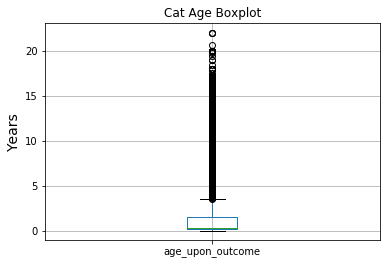

In [32]:
# cat age plot

catagepandas['age_upon_outcome'] = catagepandas['age_upon_outcome']/365
catagepandas.boxplot(column = ["age_upon_outcome"])
plt.ylabel("Years", fontsize = 14)
plt.title("Cat Age Boxplot")
plt.show()

Most cats have age lower than 4 years. There are many outliers in the plot.  

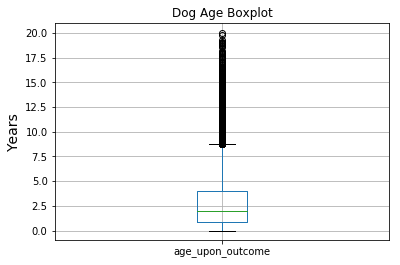

In [33]:
# dog age plot

dogagepandas['age_upon_outcome'] = dogagepandas['age_upon_outcome']/365
dogagepandas.boxplot(column = ["age_upon_outcome"])
plt.ylabel("Years", fontsize = 14)
plt.title("Dog Age Boxplot")
plt.show()

Most dogs have age lower than 8 years. There are many outliers in the plot.  

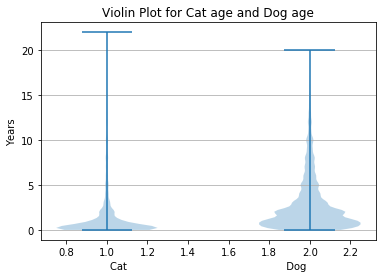

In [34]:
# cat age and dog age violin plot

fig, axes = plt.subplots()
axes.violinplot(dataset = [catagepandas['age_upon_outcome'].values, 
                           dogagepandas['age_upon_outcome'].values])

axes.set_title('Violin Plot for Cat age and Dog age')
axes.yaxis.grid(True)
axes.set_xlabel('Cat                                                   Dog')
axes.set_ylabel('Years')

plt.show()

We can see from the violin plot that the eldest cat is elder than the eldest dog. The age distribution of dog is more even that that of cats.  

### 3.2.2 Amount of acitivity records in Astin Animal Shelter by month

We want to see the line chart of amount of activities. 

In [35]:
# calculate number of animals coming by month

dog_cat_shelterdata_for_eda.select(date_format(dog_cat_shelterdata_for_eda['monthyear'],"yyyy-MM").alias('ts').cast("date"))
dog_cat_shelterdata_for_eda_timeSplit = dog_cat_shelterdata_for_eda.withColumn("Year_month", date_format(dog_cat_shelterdata_for_eda['monthyear'],"yyyy-MM"))
Year_month_count = dog_cat_shelterdata_for_eda_timeSplit.groupBy("Year_month").count().orderBy("Year_month")
Year_month_count = Year_month_count.where(Year_month_count['Year_month']<="2017-12")
Year_month_count.show(10)

+----------+-----+
|Year_month|count|
+----------+-----+
|   2013-10| 1528|
|   2013-11| 1257|
|   2013-12| 1428|
|   2014-01| 1201|
|   2014-02| 1023|
|   2014-03| 1222|
|   2014-04| 1251|
|   2014-05| 1480|
|   2014-06| 1596|
|   2014-07| 1965|
+----------+-----+
only showing top 10 rows



Here are top 10 months with most records:

In [36]:
Year_month_count.orderBy(desc("count")).show(10)

+----------+-----+
|Year_month|count|
+----------+-----+
|   2014-07| 1965|
|   2015-07| 1743|
|   2014-08| 1695|
|   2015-06| 1679|
|   2017-07| 1601|
|   2014-06| 1596|
|   2015-05| 1589|
|   2017-08| 1550|
|   2015-08| 1538|
|   2014-09| 1531|
+----------+-----+
only showing top 10 rows



We could see from the results that June, July and Augest are peak months for accomdodating new animals.

Text(0.5, 1.0, 'Amount of activities in Astin Animal Shelter')

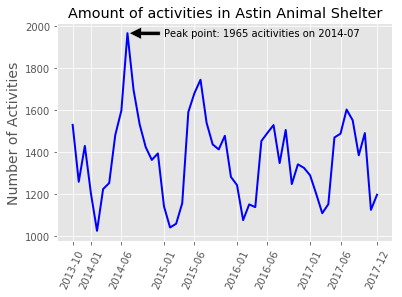

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(111)
Year_month_count_pd = Year_month_count.toPandas()
x=Year_month_count_pd.iloc[:,0]
y=Year_month_count_pd.iloc[:,1]

line, = ax.plot(x, y, color='b',lw=2)
ax.annotate('Peak point: 1965 acitivities on 2014-07', xy=('2014-07', 1965), xytext=("2015-01", 1950),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.xticks(rotation=65)
plt.xticks(['2013-10','2014-01','2014-06','2015-01','2015-06','2016-01','2016-06','2017-01','2017-06','2017-12'])
plt.ylabel("Number of Activities", fontsize = 14)
plt.title('Amount of activities in Astin Animal Shelter')

We can clearly see the seasonal pattern in the line chart, i.e. The amount of acitivties increases from the bottom, winter, to the top, summer. The peak point was 1965, happened in July 2014.   

### 3.2.3 Sex

We want to see the sex structure of animals sent to the shelter.

Text(0.5, 1.0, 'Sex information of cats')

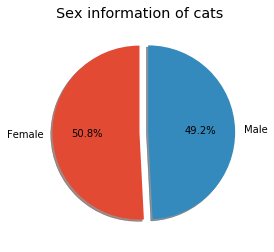

In [38]:
# summary of cat sex

cat_sex = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Cat").select(col("sex")).groupBy("sex").count()
cat_sex_pd = cat_sex.toPandas()
plt.pie(cat_sex_pd["count"],explode=(0,0.1), labels=["Female","Male"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Sex information of cats')

Text(0.5, 1.0, 'Sex information of dogs')

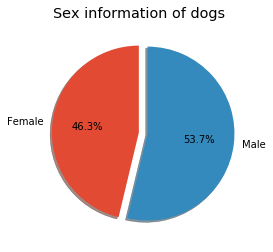

In [39]:
# summary of dog sex

dog_sex = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Dog").select(col("sex")).groupBy("sex").count()
dog_sex_pd = dog_sex.toPandas()
plt.pie(dog_sex_pd["count"],explode=(0,0.1), labels=["Female","Male"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Sex information of dogs')

We see female cats account for a slightly bigger part and so do male dogs. Overall, we do not find huge differnce in the number of female and male animals.

### 3.2.4 Color

We are given the exact data of animal colors, i.e. we know all colors that an animal has. The intuition here is to divide the animals into two groups, one with single color and the other with multiple colors, and do not make further classification for multiple color animals. Since multiple colors are separated by a slash, we count the number of slash of each cell and create a new column named "color_num". We could also use this column as a new variable in the prediction process.

Text(0.5, 1.0, 'Color information of cats')

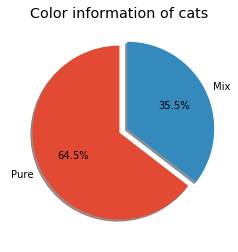

In [40]:
# summary of cat color

cat_color = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Cat").select(col("is_sc")).groupBy("is_sc").count()
cat_color_pd = cat_color.toPandas()
plt.pie(cat_color_pd["count"],explode=(0,0.1), labels=["Pure","Mix"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Color information of cats')

Text(0.5, 1.0, 'Color information of dogs')

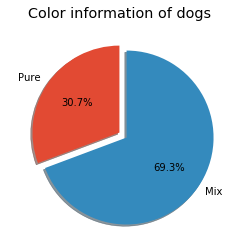

In [41]:
# summary of dog color

dog_color = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Dog").select(col("is_sc")).groupBy("is_sc").count()
dog_color_pd = dog_color.toPandas()
plt.pie(dog_color_pd["count"],explode=(0,0.1), labels=["Pure","Mix"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Color information of dogs')

We see that cats are mainly with one single color, and dogs are more likely to have multiple colors.

### 3.2.5 Fertility

We want to see how many animals are able to give babies and whether people like this feature or not.

Text(0.5, 1.0, 'Fertility information of cats')

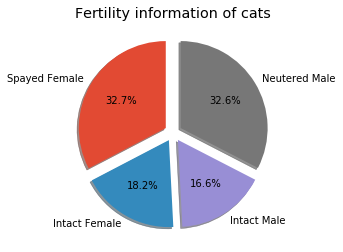

In [42]:
# summary of cat fertility

cat_fer = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Cat").select(col("reproduction"),col("sex")).groupBy("sex","reproduction").count()
cat_fer_pd = cat_fer.toPandas()
plt.pie(cat_fer_pd["count"],explode=(0.1,0.1,0.1,0.1), labels=["Spayed Female","Intact Female","Intact Male","Neutered Male"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Fertility information of cats')

Text(0.5, 1.0, 'Fertility information of dogs')

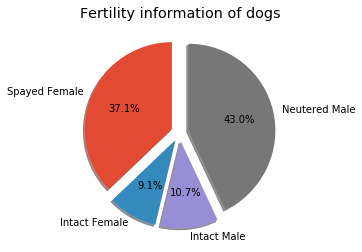

In [43]:
# summary of dog fertility

dog_fer = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Dog").select(col("reproduction"),col("sex")).groupBy("sex","reproduction").count()
dog_fer_pd = dog_fer.toPandas()
plt.pie(dog_fer_pd["count"],explode=(0.1,0.1,0.1,0.1), labels=["Spayed Female","Intact Female","Intact Male","Neutered Male"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Fertility information of dogs')

The result shows that most of the animals are unable to give babies no matter for male or female, dogs or cats. And this ratio is even higher for dogs.

### 3.2.6 Outcome

There're eight outcomes for animals: adoption, transfer, return to owner, euthanasia, died, rto-adopt, missing and disposal. We want to see the number of animals in each category.

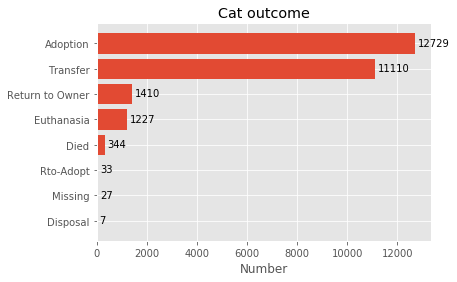

In [44]:
# summary of cat outcome type

cat_out = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Cat").select(col("outcome_type")).groupBy("outcome_type").count().orderBy("count")
cat_out_pd = cat_out.toPandas()

label = list(cat_out_pd["outcome_type"].values)
index = np.arange(len(label))
bars = plt.barh(index,cat_out_pd["count"],align="center")
plt.yticks(index, label, fontsize=10)
plt.xlabel('Number')
plt.title("Cat outcome")
for bar in bars:
    xval = bar.get_width()
    plt.text(xval+100, bar.get_y()+0.3, xval)
plt.show()

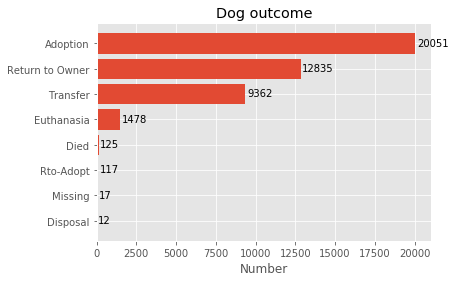

In [45]:
# summary of dog outcome type

dog_out = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Dog").select(col("outcome_type")).groupBy("outcome_type").count().orderBy("count")
dog_out_pd = dog_out.toPandas()

label = list(dog_out_pd["outcome_type"].values)
index = np.arange(len(label))
bars = plt.barh(index,dog_out_pd["count"],align="center")
plt.yticks(index, label, fontsize=10)
plt.xlabel('Number')
plt.title("Dog outcome")
for bar in bars:
    xval = bar.get_width()
    plt.text(xval+100, bar.get_y()+0.3, xval)
plt.show()

We see that most animals are adopted, many are returned to the owner which is good, some transfer to other places (maybe other shelters or hospitals), and the rest five outcomes account for a very small part. Our goal is to look into the features of those animals that got adopted.

### 3.2.7 Number of times an animal was sent to the shelter

It's interesting to know that one animal may be sent to the shelter many times, though this rarely happens. Some of them escaped from the new home and was resent to thier owner many times. A few of them were returned by thier onwer back to the shelter and are waiting for a new owner.

In [46]:
# number of times that an animal was sent to the shelter

cat_time = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Cat").select(col("animal_id")).groupBy("animal_id").count()
cat_time = cat_time.withColumn("resend",col("count")!=1)
cat_time_count = cat_time.select(col("count").alias("cat_send_num"))\
    .groupBy("cat_send_num")\
    .count()\
    .orderBy(desc("cat_send_num"))

dog_time = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Dog").select(col("animal_id")).groupBy("animal_id").count()
dog_time = dog_time.withColumn("resend",col("count")!=1)
dog_time_count = dog_time.select(col("count").alias("dog_send_num"))\
    .groupBy("dog_send_num")\
    .count()\
    .orderBy(desc("dog_send_num"))

In [47]:
cat_time_count.show()
dog_time_count.show()

+------------+-----+
|cat_send_num|count|
+------------+-----+
|           5|    1|
|           4|    3|
|           3|   96|
|           2|  998|
|           1|24586|
+------------+-----+

+------------+-----+
|dog_send_num|count|
+------------+-----+
|          11|    2|
|          10|    1|
|           8|    3|
|           7|    6|
|           6|   23|
|           5|   61|
|           4|  181|
|           3|  716|
|           2| 3744|
|           1|33096|
+------------+-----+



Most of the animals only have one record and some of them are resent to the shelter a couple of times. The most naughty dog got lost 10 times after being adopted by an owner!

# 4. Feature engineering

## 4.1 Data preprocessing for feature transformation

We now want to split the dataframe into two individual parts, one for dogs and one for cats, each containing six variables: age, color, sex, fertility, quarter and if_weekday. Later we may take breed and name information into account, and even take animal type as an independent variable. To do this, we need to delete unuseful columns, convert useful ones into binary varialbes, and convert the timestamp to two separate columns: month and day.

In [48]:
# split the dataframe and keep the columns we're going to make use of

df_dog = dog_cat_shelterdata.where(col("animal_type")=="Dog")
df_cat = dog_cat_shelterdata.where(col("animal_type")=="Cat")

df_dog = df_dog.select("age_upon_outcome", "is_sc", "sex", "reproduction", "monthyear", "outcome_type")
df_cat = df_cat.select("age_upon_outcome", "is_sc", "sex", "reproduction", "monthyear", "outcome_type")

In [49]:
# convert column "outcome_type" to a binary variable (i.e. adopted or not)

df_dog = df_dog.withColumn("outcome_type", (df_dog["outcome_type"]=="Adoption").cast("int"))
df_cat = df_cat.withColumn("outcome_type", (df_cat["outcome_type"]=="Adoption").cast("int"))

In [50]:
# split column "monthyear" into month and day, and convert to "quarter" & is_wkd"

df_dog = df_dog.withColumn("monthyear", to_date("monthyear","yyyy-MM-dd'T'HH:mm:ss"))
df_dog = df_dog.withColumn("month", month("monthyear"))
df_dog = df_dog.withColumn("day", dayofweek("monthyear"))
df_dog = df_dog.withColumn("is_wkd", when(df_dog["day"]>5, 0).otherwise(1)).drop(df_dog["day"])

df_cat = df_cat.withColumn("monthyear", to_date("monthyear","yyyy-MM-dd'T'HH:mm:ss"))
df_cat = df_cat.withColumn("month", month("monthyear"))
df_cat = df_cat.withColumn("day", dayofweek("monthyear"))
df_cat = df_cat.withColumn("is_wkd", when(df_cat["day"]>5, 0).otherwise(1)).drop(df_cat["day"])

cond = """case when month > 9 then 'Q4'
            else case when month > 6 then 'Q3'
                else case when month > 3 then 'Q2'
                    else case when month > 0 then 'Q1'
                        end
                    end
                end
            end as quarter"""

df_dog = df_dog.withColumn("quarter", expr(cond))
df_cat = df_cat.withColumn("quarter", expr(cond))

In [51]:
# convert age in days into years

from pyspark.sql.functions import round
df_dog = df_dog.withColumn("age", round(df_dog["age_upon_outcome"]/365,1))
df_cat = df_cat.withColumn("age", round(df_cat["age_upon_outcome"]/365,1))

In [52]:
# convert column "reproduction" into binary variable

df_dog = df_dog.withColumn("reproduction", when(df_dog["reproduction"]=="Intact", 1).otherwise(0))
df_cat = df_cat.withColumn("reproduction", when(df_cat["reproduction"]=="Intact", 1).otherwise(0))

In [53]:
# keep only useful columns

df_dog_fct = df_dog.select("age", "is_sc", "sex", "reproduction", "quarter", "is_wkd", "outcome_type")
df_cat_fct = df_cat.select("age", "is_sc", "sex", "reproduction", "quarter", "is_wkd", "outcome_type")

In [54]:
# check the first several rows

df_dog_fct.show(5)
df_cat_fct.show(5)

+---+-----+------+------------+-------+------+------------+
|age|is_sc|   sex|reproduction|quarter|is_wkd|outcome_type|
+---+-----+------+------------+-------+------+------------+
|1.0|    0|Female|           0|     Q4|     1|           0|
|1.2|    0|  Male|           0|     Q2|     1|           1|
|9.0|    1|  Male|           0|     Q2|     1|           0|
|0.3|    0|  Male|           1|     Q4|     1|           0|
|3.0|    1|Female|           0|     Q4|     1|           0|
+---+-----+------+------------+-------+------+------------+
only showing top 5 rows

+---+-----+------+------------+-------+------+------------+
|age|is_sc|   sex|reproduction|quarter|is_wkd|outcome_type|
+---+-----+------+------------+-------+------+------------+
|0.0|    1|  Male|           1|     Q3|     1|           0|
|0.2|    0|Female|           1|     Q3|     1|           1|
|0.3|    0|Female|           0|     Q2|     1|           1|
|1.0|    0|Female|           0|     Q1|     0|           0|
|0.1|    0|  Ma

## 4.2 Feature transformation

Now we have all six features in a clean dataframe: age, sex, reproduction, is_singleColor, quarter, is_weekday. We want then to test the correlation among these variables. Since our data contains text, we use RFormula to transform these features all into figures.

In [55]:
# construct an RFormula

from pyspark.ml.feature import RFormula
RF = RFormula(formula="outcome_type ~ .")

In [56]:
# fit and transform

dog_feature = RF.fit(df_dog_fct).transform(df_dog_fct)
dog_feature.show(5, False)

+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
|age|is_sc|sex   |reproduction|quarter|is_wkd|outcome_type|features                         |label|
+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
|1.0|0    |Female|0           |Q4     |1     |0           |(8,[0,4,7],[1.0,1.0,1.0])        |0.0  |
|1.2|0    |Male  |0           |Q2     |1     |1           |(8,[0,2,6,7],[1.2,1.0,1.0,1.0])  |1.0  |
|9.0|1    |Male  |0           |Q2     |1     |0           |[9.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0]|0.0  |
|0.3|0    |Male  |1           |Q4     |1     |0           |[0.3,0.0,1.0,1.0,1.0,0.0,0.0,1.0]|0.0  |
|3.0|1    |Female|0           |Q4     |1     |0           |(8,[0,1,4,7],[3.0,1.0,1.0,1.0])  |0.0  |
+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
only showing top 5 rows



In [57]:
cat_feature = RF.fit(df_cat_fct).transform(df_cat_fct)
cat_feature.show(5, False)

+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
|age|is_sc|sex   |reproduction|quarter|is_wkd|outcome_type|features                         |label|
+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
|0.0|1    |Male  |1           |Q3     |1     |0           |(8,[1,3,4,7],[1.0,1.0,1.0,1.0])  |0.0  |
|0.2|0    |Female|1           |Q3     |1     |1           |[0.2,0.0,1.0,1.0,1.0,0.0,0.0,1.0]|1.0  |
|0.3|0    |Female|0           |Q2     |1     |1           |(8,[0,2,6,7],[0.3,1.0,1.0,1.0])  |1.0  |
|1.0|0    |Female|0           |Q1     |0     |0           |(8,[0,2],[1.0,1.0])              |0.0  |
|0.1|0    |Male  |1           |Q1     |1     |0           |(8,[0,3,7],[0.1,1.0,1.0])        |0.0  |
+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
only showing top 5 rows



## 4.3 Correlation examination

Now that we have the feature vector, we could look into pairwise correlation and visualize the corr matrix.

In [58]:
dog_transformed_feature = dog_feature.select("features")
dog_transformed_feature_pd = dog_transformed_feature.toPandas()

dog_feature_mat = dog_transformed_feature_pd['features'].apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)
dog_feature_arr = np.apply_along_axis(lambda x : x[0], 1, dog_feature_mat)

labels1 = ["age", "color", "sex", "reproduction", "Q4", "Q1", "Q2", "weekday"]
dog_feature_pd = pd.DataFrame(dog_feature_arr, columns=labels1)
dog_feature_pd.head()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,age,color,sex,reproduction,Q4,Q1,Q2,weekday
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.2,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,9.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.3,0.0,1.0,1.0,1.0,0.0,0.0,1.0
4,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [59]:
cat_transformed_feature = cat_feature.select("features")
cat_transformed_feature_pd = cat_transformed_feature.toPandas()

cat_feature_mat = cat_transformed_feature_pd['features'].apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)
cat_feature_arr = np.apply_along_axis(lambda x : x[0], 1, cat_feature_mat)

labels2 = ["age", "color", "sex", "reproduction", "Q3", "Q4", "Q2", "weekday"]
cat_feature_pd = pd.DataFrame(cat_feature_arr, columns=labels2)
cat_feature_pd.head()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,age,color,sex,reproduction,Q3,Q4,Q2,weekday
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.2,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,0.3,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.1,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [60]:
!pip install seaborn
import seaborn as sns

In [61]:
dog_feature_corr_mat = dog_feature_pd.corr().round(2)
cat_feature_corr_mat = cat_feature_pd.corr().round(2)

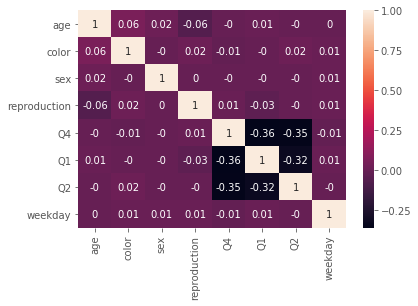

In [62]:
sns.heatmap(dog_feature_corr_mat, annot=True)

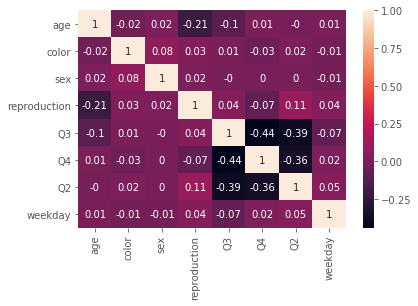

In [63]:
sns.heatmap(cat_feature_corr_mat, annot=True)

# 5. Classification models and prediction

We first import necessary packages and construct evaluators.

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import *

In [65]:
# construct AUC evaluator

from pyspark.ml.evaluation import BinaryClassificationEvaluator
aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

In [66]:
# construct accuracy evaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")

In [67]:
# construct precision evaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
prcEvaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")

In [68]:
# construct recall evaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
recEvaluator = MulticlassClassificationEvaluator(metricName="weightedRecall")

In [69]:
# construct F1 evaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
f1Evaluator = MulticlassClassificationEvaluator(metricName="f1")

## 5.1 Logistic Regression

### 5.1.1 Dog prediction

In [70]:
dog_feature.cache()
print("The dog dataset consists of {} rows.".format(dog_feature.count()))

The dog dataset consists of 43997 rows.


In [71]:
# get feature names in the features vector

dog_featureCols = pd.DataFrame(dog_feature.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  dog_feature.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

dog_featureCols = dog_featureCols.set_index('idx')
dog_featureCols.head()

,name
idx,
0,age
1,is_sc
2,sex_Male
3,reproduction
4,quarter_Q4


In [72]:
# set up LogisticRegression model

from pyspark.ml.classification import LogisticRegression
dog_train, dog_test = dog_feature.randomSplit([0.7, 0.3], seed=843)
dog_lr = LogisticRegression()
dog_lrModel = dog_lr.fit(dog_train)

Text(0, 0.5, 'Dog Beta Coefficients')

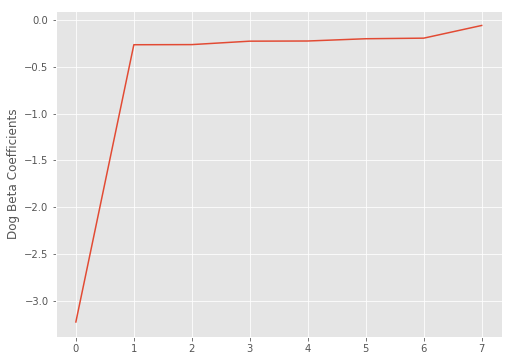

In [73]:
# plot the coefficients in the LogisticRegression model

plt.rcParams["figure.figsize"] = (8,6)
beta = np.sort(dog_lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Dog Beta Coefficients')

In [74]:
# match the coefficients with feature names

dog_coefsArray = np.array(dog_lrModel.coefficients)  # convert to np.array
dog_coefsDF = pd.DataFrame(dog_coefsArray, columns=['coefs'])  # to pandas

dog_coefsDF =dog_coefsDF.merge(dog_featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
dog_coefsDF.sort_values('coefs', inplace=True)  # Sort them
dog_coefsDF.head()

,coefs,name
3,-3.228192,reproduction
6,-0.263252,quarter_Q2
7,-0.261767,is_wkd
0,-0.225044,age
4,-0.223273,quarter_Q4


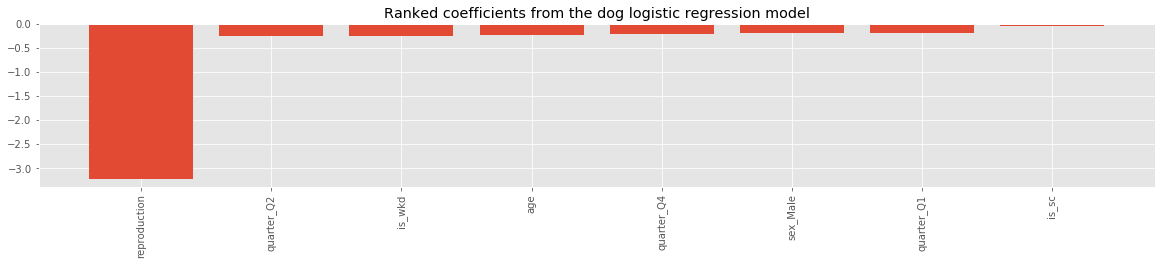

In [75]:
# plot the value of each coefficient aligned with feature name

plt.rcParams["figure.figsize"] = (20,3)
plt.xticks(rotation=90)
plt.bar(dog_coefsDF.name, dog_coefsDF.coefs)
plt.title('Ranked coefficients from the dog logistic regression model')
plt.show()

No positive coefficients in dog logistic model. People have a preference for young and female dogs with no mating ability and single color.

Text(0, 0.5, 'TPR')

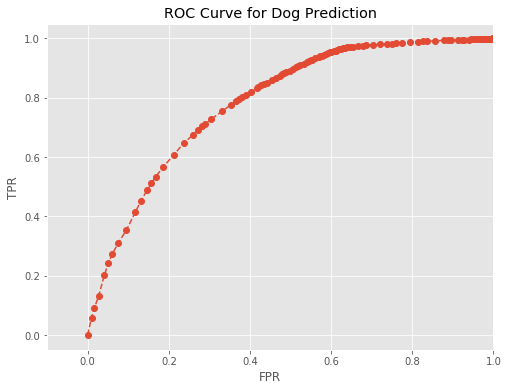

In [76]:
# plot the ROC curve

dog_summary = dog_lrModel.summary
dog_roc = dog_summary.roc.toPandas()
plt.rcParams["figure.figsize"] = (8,6)
dog_roc.plot(x='FPR', y='TPR', xlim = [-0.1, 1], style='--o', legend=False)
plt.title('ROC Curve for Dog Prediction')
plt.ylabel('TPR')

In [77]:
# show Precision-Recall under certain threshold

dog_pr = dog_summary.pr.toPandas()
dog_pr.head()

,recall,precision
0,0.000000,0.836233
1,0.058819,0.836233
2,0.091865,0.820579
3,0.132181,0.800000
4,0.200792,0.802821


In [78]:
# transform train and test data

dog_fittedTrain = dog_lrModel.transform(dog_train)
dog_fittedTest = dog_lrModel.transform(dog_test)

In [79]:
# AUC evaluator
dog_lr_train_auc = dog_summary.areaUnderROC
dog_lr_test_auc = aucEvaluator.evaluate(dog_fittedTest)

# accuracy evaluator
dog_lr_train_acc = accEvaluator.evaluate(dog_fittedTrain)
dog_lr_test_acc = accEvaluator.evaluate(dog_fittedTest)

# precision evaluator
dog_lr_train_prc = prcEvaluator.evaluate(dog_fittedTrain)
dog_lr_test_prc = prcEvaluator.evaluate(dog_fittedTest)

# recall evaluator
dog_lr_train_rec = recEvaluator.evaluate(dog_fittedTrain)
dog_lr_test_rec = recEvaluator.evaluate(dog_fittedTest)

# F1-score evaluator
dog_lr_train_f1 = f1Evaluator.evaluate(dog_fittedTrain)
dog_lr_test_f1 = f1Evaluator.evaluate(dog_fittedTest)

In [80]:
# summarize model performance

dog_lr_train_pfmc = [dog_lr_train_auc, dog_lr_train_acc, dog_lr_train_prc, dog_lr_train_rec, dog_lr_train_f1]
dog_lr_test_pfmc = [dog_lr_test_auc, dog_lr_test_acc, dog_lr_test_prc, dog_lr_test_rec, dog_lr_test_f1]

dog_lr_summary = pd.DataFrame(data=[dog_lr_train_pfmc, dog_lr_test_pfmc], columns=['AUC', 'Accuracy', 'Precision', \
                            'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('-------Dog Logistic Regression summary-------')
np.round(dog_lr_summary,4)

-------Dog Logistic Regression summary-------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.7863,0.6999,0.7205,0.6999,0.6987
Test Set,0.7898,0.7078,0.7233,0.7078,0.7066


### 5.1.2 Cat prediction

In [81]:
cat_feature.cache()
print("The cat dataset consists of {} rows.".format(cat_feature.count()))

The cat dataset consists of 26887 rows.


In [82]:
# get feature names in the features vector

cat_featureCols = pd.DataFrame(cat_feature.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  cat_feature.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

cat_featureCols = cat_featureCols.set_index('idx')
cat_featureCols.head()

,name
idx,
0,age
1,is_sc
2,sex_Female
3,reproduction
4,quarter_Q3


In [83]:
# set up LogisticRegression model

cat_train, cat_test = cat_feature.randomSplit([0.7, 0.3], seed=843)
cat_lr = LogisticRegression()
cat_lrModel = cat_lr.fit(cat_train)

Text(0, 0.5, 'Cat Beta Coefficients')

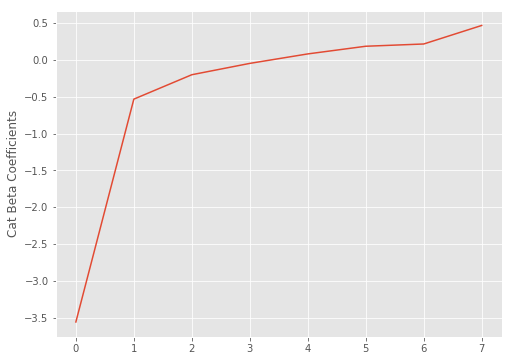

In [84]:
# plot the coefficients in the LogisticRegression model

plt.rcParams["figure.figsize"] = (8,6)
beta = np.sort(cat_lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Cat Beta Coefficients')

In [85]:
# match the coefficients with feature names

cat_coefsArray = np.array(cat_lrModel.coefficients)  # convert to np.array
cat_coefsDF = pd.DataFrame(cat_coefsArray, columns=['coefs'])  # to pandas

cat_coefsDF =cat_coefsDF.merge(cat_featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
cat_coefsDF.sort_values('coefs', inplace=True)  # Sort them
cat_coefsDF.head()

,coefs,name
3,-3.559119,reproduction
7,-0.530880,is_wkd
0,-0.199346,age
1,-0.045337,is_sc
6,0.083375,quarter_Q2


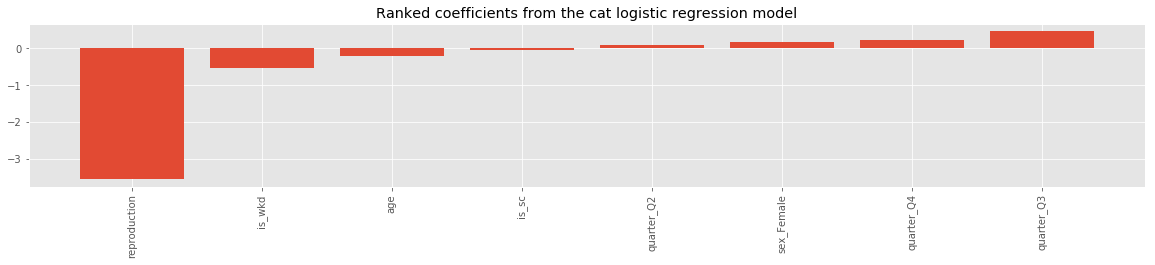

In [86]:
# plot the value of each coefficient aligned with feature name

plt.rcParams["figure.figsize"] = (20,3)
plt.xticks(rotation=90)
plt.bar(cat_coefsDF.name, cat_coefsDF.coefs)
plt.title('Ranked coefficients from the cat logistic regression model')
plt.show()

We see people have a preference for female and young cats with no mating ability and single color.

Text(0, 0.5, 'TPR')

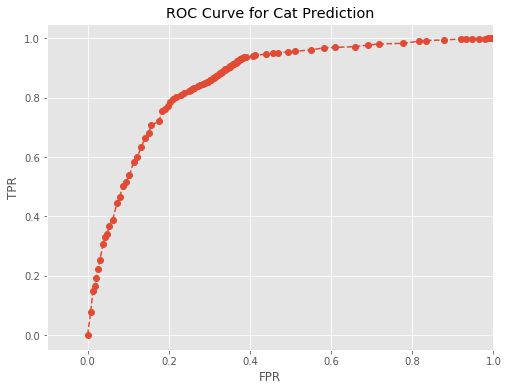

In [87]:
# plot the ROC curve

cat_summary = cat_lrModel.summary
cat_roc = cat_summary.roc.toPandas()
plt.rcParams["figure.figsize"] = (8,6)
cat_roc.plot(x='FPR', y='TPR', xlim = [-0.1, 1], style='--o', legend=False)
plt.title('ROC Curve for Cat Prediction')
plt.ylabel('TPR')

In [88]:
# show Precision-Recall under certain threshold

cat_pr = cat_summary.pr.toPandas()
cat_pr.head()

,recall,precision
0,0.000000,0.905388
1,0.076940,0.905388
2,0.147292,0.911541
3,0.164266,0.889359
4,0.193412,0.890031


In [89]:
# transform train and test data

cat_fittedTrain = cat_lrModel.transform(cat_train)
cat_fittedTest = cat_lrModel.transform(cat_test)

In [90]:
# AUC evaluator
cat_lr_train_auc = cat_summary.areaUnderROC
cat_lr_test_auc = aucEvaluator.evaluate(cat_lrModel.transform(cat_test))

# accuracy evaluator
cat_lr_train_acc = accEvaluator.evaluate(cat_fittedTrain)
cat_lr_test_acc = accEvaluator.evaluate(cat_fittedTest)

# precision evaluator
cat_lr_train_prc = prcEvaluator.evaluate(cat_fittedTrain)
cat_lr_test_prc = prcEvaluator.evaluate(cat_fittedTest)

# recall evaluator
cat_lr_train_rec = recEvaluator.evaluate(cat_fittedTrain)
cat_lr_test_rec = recEvaluator.evaluate(cat_fittedTest)

# F1-score evaluator
cat_lr_train_f1 = f1Evaluator.evaluate(cat_fittedTrain)
cat_lr_test_f1 = f1Evaluator.evaluate(cat_fittedTest)

In [91]:
# summarize model performance

cat_lr_train_pfmc = [cat_lr_train_auc, cat_lr_train_acc, cat_lr_train_prc, cat_lr_train_rec, cat_lr_train_f1]
cat_lr_test_pfmc = [cat_lr_test_auc, cat_lr_test_acc, cat_lr_test_prc, cat_lr_test_rec, cat_lr_test_f1]

cat_lr_summary = pd.DataFrame(data=[cat_lr_train_pfmc, cat_lr_test_pfmc], columns=['AUC', 'Accuracy', 'Precision', \
                            'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('-------Cat Logistic Regression summary-------')
np.round(cat_lr_summary,4)

-------Cat Logistic Regression summary-------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.8586,0.7744,0.7889,0.7744,0.7731
Test Set,0.8633,0.7821,0.7959,0.7821,0.7814


### 5.1.3 Statistic Summary of Logistic Regression (with `sklearn` and `statsmodels`)

Unfortunately `pyspark.ml` does not provide easy access to model coefficient significance. However, it's very important for us to know this, otherwise we could say nothing about a feature's influence on prediction result (statistically). So here we use `statsmodels` package to implement t-test on coefficients.

In [92]:
!pip install --upgrade pip py4j

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (19.1)
Requirement already up-to-date: py4j in /opt/conda/lib/python3.6/site-packages (0.10.8.1)


In [93]:
# machine learning/predictive analytics tools
!pip install sklearn
!pip install statsmodels
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# date and timeseries forecasting tooling
import datetime

In [94]:
# convert cleaned Spark dataframe into pandas dataframe

pd_df_dog_fct = df_dog_fct.toPandas()
print("The shape of dog pandas dataframe is {}.".format(pd_df_dog_fct.shape))

The shape of dog pandas dataframe is (43997, 7).


In [95]:
# convert non-numerical feature to dummies

df_dog_dummies=pd.get_dummies(pd_df_dog_fct, drop_first=True)
df_dog_dummies.head()

,age,is_sc,reproduction,is_wkd,outcome_type,sex_Male,quarter_Q2,quarter_Q3,quarter_Q4
0,1.0,0,0,1,0,0,0,0,1
1,1.2,0,0,1,1,1,1,0,0
2,9.0,1,0,1,0,1,1,0,0
3,0.3,0,1,1,0,1,0,0,1
4,3.0,1,0,1,0,0,0,0,1


In [96]:
# split train and test data with the same seed as we use in Spark MLlib, and set up dependent and independent variables

train_dog, test_dog = train_test_split(df_dog_dummies, test_size=0.3, random_state=843)
y_dog = train_dog["outcome_type"]
x_dog = train_dog.loc[:, train_dog.columns != 'outcome_type']

In [97]:
# get statistic summary of logistic Regression

logit_dog = sm.Logit(y_dog, x_dog)
logit_dog.fit().summary()

Optimization terminated successfully.
         Current function value: 0.567379
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           outcome_type   No. Observations:                30797
Model:                          Logit   Df Residuals:                    30789
Method:                           MLE   Df Model:                            7
Date:                Wed, 01 May 2019   Pseudo R-squ.:                  0.1765
Time:                        01:54:13   Log-Likelihood:                -17474.
converged:                       True   LL-Null:                       -21218.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
age             -0.1790      0.005    -38.778      0.000      -0.188      -0.170
is_sc            0.1184      0.028      4.301      0.000       0.064       0.172
reproduction    -3.0475      0.056    -54.762      0.000      -3.157      -2.938
is_wkd           0.1831      0.024      7.561      0.000       0.136       0.231
sex_Male         0.0635      0.024      2.619      0.009       0.016       0.111
quarter_Q2       0.4745      0.033     14.477      0.000       0.410       0.539
quarter_Q3       0.6823      0.033     20.560      0.000       0.617       0.747
quarter_Q4       0.4658      0.031     15.134      0.000       0.405       0.526
================================================================================
"""

We see all z-scores are above 1.96 cutoff, or say all p_values are lower than 0.05 threshold. Thus all coefficients are significant under 95% confidence level convention. Our Logistic Regression model seems good!

Then how about cats?

In [98]:
# convert cleaned Spark dataframe into pandas dataframe

pd_df_cat_fct = df_cat_fct.toPandas()
print("The shape of cat pandas dataframe is {}.".format(pd_df_cat_fct.shape))

The shape of cat pandas dataframe is (26887, 7).


In [99]:
# convert non-numerical feature to dummies

df_cat_dummies=pd.get_dummies(pd_df_cat_fct, drop_first=True)
df_cat_dummies.head()

,age,is_sc,reproduction,is_wkd,outcome_type,sex_Male,quarter_Q2,quarter_Q3,quarter_Q4
0,0.0,1,1,1,0,1,0,1,0
1,0.2,0,1,1,1,0,0,1,0
2,0.3,0,0,1,1,0,1,0,0
3,1.0,0,0,0,0,0,0,0,0
4,0.1,0,1,1,0,1,0,0,0


In [100]:
# split train and test data with the same seed as we use in Spark MLlib, and set up dependent and independent variables

train_cat, test_cat = train_test_split(df_cat_dummies, test_size=0.3, random_state=843)
y_cat = train_cat["outcome_type"]
x_cat = train_cat.loc[:, train_cat.columns != 'outcome_type']

In [101]:
# get statistic summary of logistic Regression

logit_cat = sm.Logit(y_cat, x_cat)
logit_cat.fit().summary()

Optimization terminated successfully.
         Current function value: 0.481339
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           outcome_type   No. Observations:                18820
Model:                          Logit   Df Residuals:                    18812
Method:                           MLE   Df Model:                            7
Date:                Wed, 01 May 2019   Pseudo R-squ.:                  0.3041
Time:                        01:54:15   Log-Likelihood:                -9058.8
converged:                       True   LL-Null:                       -13018.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
age             -0.1624      0.006    -25.149      0.000      -0.175      -0.150
is_sc            0.2993      0.035      8.583      0.000       0.231       0.368
reproduction    -3.4573      0.052    -66.738      0.000      -3.559      -3.356
is_wkd          -0.0907      0.036     -2.539      0.011      -0.161      -0.021
sex_Male         0.1164      0.035      3.323      0.001       0.048       0.185
quarter_Q2       0.7620      0.050     15.101      0.000       0.663       0.861
quarter_Q3       1.2064      0.046     26.117      0.000       1.116       1.297
quarter_Q4       0.9406      0.046     20.614      0.000       0.851       1.030
================================================================================
"""

Similar to dog model, we have all z-scores above 1.96 cutoff and all p_values lower than 0.05 threshold. All coefficients are significant.

With the help of `statsmodels`, we are able to do t-test on Logreg model coefficients and conclude that all factors have a significant influence on outcome, both for dogs and cats.

## 5.2 Multilayer Perceptron Classifier

In [102]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [8, 5, 5, 2]

### 5.2.1 Dog prediction

In [103]:
# fit the multilayer perceptron classifier

mpc = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=843)
dog_mpcModel = mpc.fit(dog_train)

In [104]:
# transform train and test data

dog_fittedTrainMPC = dog_mpcModel.transform(dog_train)
dog_fittedTestMPC = dog_mpcModel.transform(dog_test)

In [105]:
# AUC evaluator
dog_mpc_train_auc = aucEvaluator.evaluate(dog_fittedTrainMPC)
dog_mpc_test_auc = aucEvaluator.evaluate(dog_fittedTestMPC)

# accuracy evaluator
dog_mpc_train_acc = accEvaluator.evaluate(dog_fittedTrainMPC)
dog_mpc_test_acc = accEvaluator.evaluate(dog_fittedTestMPC)

# precision evaluator
dog_mpc_train_prc = prcEvaluator.evaluate(dog_fittedTrainMPC)
dog_mpc_test_prc = prcEvaluator.evaluate(dog_fittedTestMPC)

# recall evaluator
dog_mpc_train_rec = recEvaluator.evaluate(dog_fittedTrainMPC)
dog_mpc_test_rec = recEvaluator.evaluate(dog_fittedTestMPC)

# F1-score evaluator
dog_mpc_train_f1 = f1Evaluator.evaluate(dog_fittedTrainMPC)
dog_mpc_test_f1 = f1Evaluator.evaluate(dog_fittedTestMPC)

In [106]:
# summarize model performance

dog_mpc_train_pfmc = [dog_mpc_train_auc, dog_mpc_train_acc, dog_mpc_train_prc, dog_mpc_train_rec, dog_mpc_train_f1]
dog_mpc_test_pfmc = [dog_mpc_test_auc, dog_mpc_test_acc, dog_mpc_test_prc, dog_mpc_test_rec, dog_mpc_test_f1]

dog_mpc_summary = pd.DataFrame(data=[dog_mpc_train_pfmc, dog_mpc_test_pfmc], columns=['AUC', 'Accuracy', 'Precision', \
                            'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('------------Dog MPC Model summary------------')
np.round(dog_mpc_summary,4)

------------Dog MPC Model summary------------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.7937,0.7116,0.7130,0.7116,0.7120
Test Set,0.7957,0.7141,0.7146,0.7141,0.7143


### 5.2.2 Cat prediction

In [107]:
# fit the multilayer perceptron classifier

cat_mpcModel = mpc.fit(cat_train)

In [108]:
# transform train and test data

cat_fittedTrainMPC = cat_mpcModel.transform(cat_train)
cat_fittedTestMPC = cat_mpcModel.transform(cat_test)

In [109]:
# AUC evaluator
cat_mpc_train_auc = aucEvaluator.evaluate(cat_fittedTrainMPC)
cat_mpc_test_auc = aucEvaluator.evaluate(cat_fittedTestMPC)

# accuracy evaluator
cat_mpc_train_acc = accEvaluator.evaluate(cat_fittedTrainMPC)
cat_mpc_test_acc = accEvaluator.evaluate(cat_fittedTestMPC)

# precision evaluator
cat_mpc_train_prc = prcEvaluator.evaluate(cat_fittedTrainMPC)
cat_mpc_test_prc = prcEvaluator.evaluate(cat_fittedTestMPC)

# recall evaluator
cat_mpc_train_rec = recEvaluator.evaluate(cat_fittedTrainMPC)
cat_mpc_test_rec = recEvaluator.evaluate(cat_fittedTestMPC)

# F1-score evaluator
cat_mpc_train_f1 = f1Evaluator.evaluate(cat_fittedTrainMPC)
cat_mpc_test_f1 = f1Evaluator.evaluate(cat_fittedTestMPC)

In [110]:
cat_mpc_train_pfmc = [cat_mpc_train_auc, cat_mpc_train_acc, cat_mpc_train_prc, cat_mpc_train_rec, cat_mpc_train_f1]
cat_mpc_test_pfmc = [cat_mpc_test_auc, cat_mpc_test_acc, cat_mpc_test_prc, cat_mpc_test_rec, cat_mpc_test_f1]

cat_mpc_summary = pd.DataFrame(data=[cat_mpc_train_pfmc, cat_mpc_test_pfmc], columns=['AUC', 'Sccuracy', 'Precision', \
                            'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('------------Cat MPC Model summary------------')
np.round(cat_mpc_summary,4)

------------Cat MPC Model summary------------


,AUC,Sccuracy,Precision,Recall,F1
Train Set,0.8920,0.8088,0.8101,0.8088,0.8081
Test Set,0.8914,0.8104,0.8112,0.8104,0.8097


## 5.3 Support vector machine (SVM)

In [111]:
from pyspark.ml.classification import LinearSVC

### 5.3.1 Dog prediction

In [112]:
# set up SVM

dog_svm = LinearSVC(maxIter=10, regParam=0.1)
dog_svmModel = dog_svm.fit(dog_train)

In [113]:
# check class number and feature number (to see if they are in line with model settings)

dog_svm_classNum = dog_svmModel.numClasses
dog_svm_featureNum = dog_svmModel.numFeatures
print("The number of classes in the dog svm model is: {}".format(dog_svm_classNum))
print("The number of features in the dog svm model is: {}".format(dog_svm_featureNum))

The number of classes in the dog svm model is: 2
The number of features in the dog svm model is: 8


In [114]:
# check model coefficients and intercept

dog_svm_coefs = dog_svmModel.coefficients
dog_svm_inter = dog_svmModel.intercept
print("Dog svm coefficients: {}".format(dog_svm_coefs))
print("Dog svm intercept: {}".format(dog_svm_inter))

Dog svm coefficients: [-0.18778391849114112,0.09233114180251095,0.1311256493805246,-1.568713397204784,0.13976914595216736,0.18251158040446264,0.1400724831093926,0.2048470082109606]
Dog svm intercept: 0.2571536955430168


Text(0, 0.5, 'Dog SVM Coefficients')

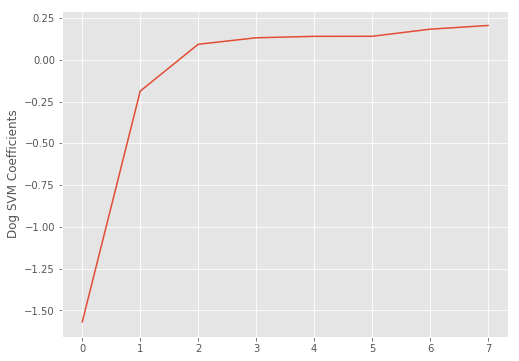

In [115]:
# plot the coefficients

plt.rcParams["figure.figsize"] = (8,6)
plt.plot(np.sort(dog_svm_coefs))
plt.ylabel('Dog SVM Coefficients')

In [116]:
# match model coefficients with feature names

dog_svm_coefsArray = np.array(dog_svm_coefs)
dog_svm_coefsDF = pd.DataFrame(dog_svm_coefsArray, columns=['coefs'])

dog_svm_coefsDF =dog_svm_coefsDF.merge(dog_featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
dog_svm_coefsDF.sort_values('coefs', inplace=True)  # Sort them
dog_svm_coefsDF.head()

,coefs,name
3,-1.568713,reproduction
0,-0.187784,age
1,0.092331,is_sc
2,0.131126,sex_Male
4,0.139769,quarter_Q4


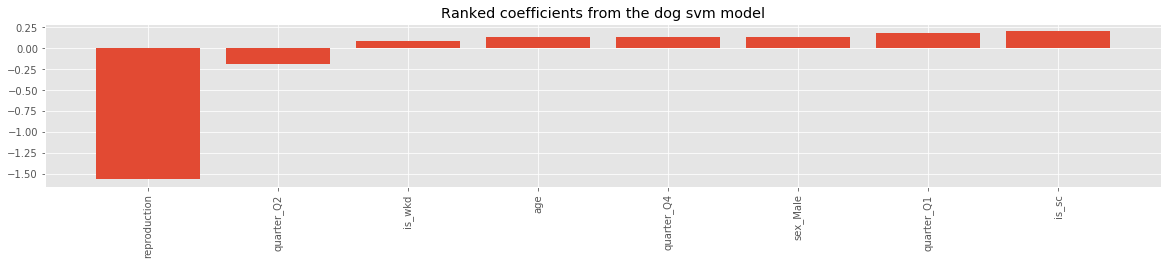

In [117]:
# plot the value of each coefficient aligned with feature name

plt.rcParams["figure.figsize"] = (20,3)
plt.xticks(rotation=90)
plt.bar(dog_coefsDF.name, dog_svm_coefsDF.coefs)
plt.title('Ranked coefficients from the dog svm model')
plt.show()

In [118]:
# transform train and test data

dog_fittedTrainSVM = dog_svmModel.transform(dog_train)
dog_fittedTestSVM = dog_svmModel.transform(dog_test)

In [119]:
# AUC evaluator
dog_svm_train_auc = aucEvaluator.evaluate(dog_fittedTrainSVM)
dog_svm_test_auc = aucEvaluator.evaluate(dog_fittedTestSVM)

# accuracy evaluator
dog_svm_train_acc = accEvaluator.evaluate(dog_fittedTrainSVM)
dog_svm_test_acc = accEvaluator.evaluate(dog_fittedTestSVM)

# precision evaluator
dog_svm_train_prc = prcEvaluator.evaluate(dog_fittedTrainSVM)
dog_svm_test_prc = prcEvaluator.evaluate(dog_fittedTestSVM)

# recall evaluator
dog_svm_train_rec = recEvaluator.evaluate(dog_fittedTrainSVM)
dog_svm_test_rec = recEvaluator.evaluate(dog_fittedTestSVM)

# F1-score evaluator
dog_svm_train_f1 = f1Evaluator.evaluate(dog_fittedTrainSVM)
dog_svm_test_f1 = f1Evaluator.evaluate(dog_fittedTestSVM)

In [120]:
# summarize model performance

dog_svm_train_pfmc = [dog_svm_train_auc, dog_svm_train_acc, dog_svm_train_prc, dog_svm_train_rec, dog_svm_train_f1]
dog_svm_test_pfmc = [dog_svm_test_auc, dog_svm_test_acc, dog_svm_test_prc, dog_svm_test_rec, dog_svm_test_f1]

dog_svm_summary = pd.DataFrame(data=[dog_svm_train_pfmc, dog_svm_test_pfmc], columns=['AUC', 'Accuracy', 'Precision', \
                            'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('------------Dog SVM Model summary------------')
np.round(dog_svm_summary,4)

------------Dog SVM Model summary------------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.7612,0.6935,0.7070,0.6935,0.6933
Test Set,0.7637,0.6988,0.7086,0.6988,0.6985


### 5.3.2 Cat prediction

In [121]:
# set up SVM

cat_svm = LinearSVC(maxIter=10, regParam=0.1)
cat_svmModel = cat_svm.fit(cat_train)

In [122]:
# check class number and feature number (to see if they are in line with model settings)

cat_svm_classNum = cat_svmModel.numClasses
cat_svm_featureNum = cat_svmModel.numFeatures
print("The number of classes in the cat svm model is: {}".format(cat_svm_classNum))
print("The number of features in the cat svm model is: {}".format(cat_svm_featureNum))

The number of classes in the cat svm model is: 2
The number of features in the cat svm model is: 8


In [123]:
# check model coefficients and intercept

cat_svm_coefs = cat_svmModel.coefficients
cat_svm_inter = cat_svmModel.intercept
print("Cat svm coefficients: {}".format(cat_svm_coefs))
print("Cat svm intercept: {}".format(cat_svm_inter))

Cat svm coefficients: [-0.11032321156548441,0.2784297562901038,0.08257526653449655,-2.0631544769716075,0.4891699216906315,0.45053583344580816,0.4434894620517951,0.10250709483718999]
Cat svm intercept: 0.2232253518076072


Text(0, 0.5, 'Cat SVM Coefficients')

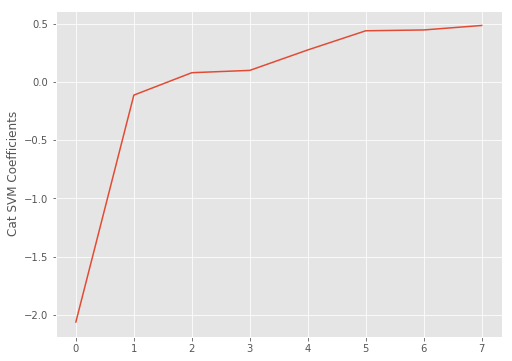

In [124]:
# plot the coefficients

plt.rcParams["figure.figsize"] = (8,6)
plt.plot(np.sort(cat_svm_coefs))
plt.ylabel('Cat SVM Coefficients')

In [125]:
# match model coefficients with feature names

cat_svm_coefsArray = np.array(cat_svm_coefs)
cat_svm_coefsDF = pd.DataFrame(cat_svm_coefsArray, columns=['coefs'])

cat_svm_coefsDF =cat_svm_coefsDF.merge(cat_featureCols, left_index=True, right_index=True)
cat_svm_coefsDF.sort_values('coefs', inplace=True)
cat_svm_coefsDF.head()

,coefs,name
3,-2.063154,reproduction
0,-0.110323,age
2,0.082575,sex_Female
7,0.102507,is_wkd
1,0.278430,is_sc


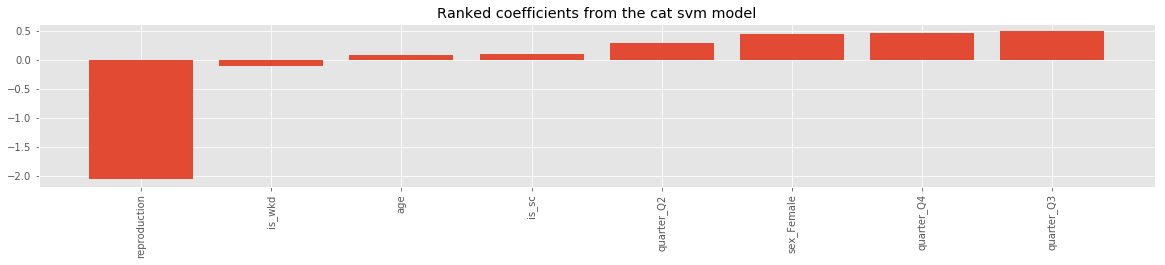

In [126]:
# plot the value of each coefficient aligned with feature name

plt.rcParams["figure.figsize"] = (20,3)
plt.xticks(rotation=90)
plt.bar(cat_coefsDF.name, cat_svm_coefsDF.coefs)
plt.title('Ranked coefficients from the cat svm model')
plt.show()

In [127]:
# transform train and test data

cat_fittedTrainSVM = cat_svmModel.transform(cat_train)
cat_fittedTestSVM = cat_svmModel.transform(cat_test)

In [128]:
# AUC evaluator
cat_svm_train_auc = aucEvaluator.evaluate(cat_fittedTrainSVM)
cat_svm_test_auc = aucEvaluator.evaluate(cat_fittedTestSVM)

# accuracy evaluator
cat_svm_train_acc = accEvaluator.evaluate(cat_fittedTrainSVM)
cat_svm_test_acc = accEvaluator.evaluate(cat_fittedTestSVM)

# precision evaluator
cat_svm_train_prc = prcEvaluator.evaluate(cat_fittedTrainSVM)
cat_svm_test_prc = prcEvaluator.evaluate(cat_fittedTestSVM)

# recall evaluator
cat_svm_train_rec = recEvaluator.evaluate(cat_fittedTrainSVM)
cat_svm_test_rec = recEvaluator.evaluate(cat_fittedTestSVM)

# F1-score evaluator
cat_svm_train_f1 = f1Evaluator.evaluate(cat_fittedTrainSVM)
cat_svm_test_f1 = f1Evaluator.evaluate(cat_fittedTestSVM)

In [129]:
# smmarize model performance

cat_svm_train_pfmc = [cat_svm_train_auc, cat_svm_train_acc, cat_svm_train_prc, cat_svm_train_rec, cat_svm_train_f1]
cat_svm_test_pfmc = [cat_svm_test_auc, cat_svm_test_acc, cat_svm_test_prc, cat_svm_test_rec, cat_svm_test_f1]

cat_svm_summary = pd.DataFrame(data=[cat_svm_train_pfmc, cat_svm_test_pfmc], columns=['AUC', 'Accuracy', 'Precision', \
                            'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('------------Cat SVM Model summary------------')
np.round(cat_svm_summary,4)

------------Cat SVM Model summary------------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.8365,0.7699,0.7910,0.7699,0.7676
Test Set,0.8403,0.7758,0.7958,0.7758,0.7743


## 5.4 Summary of model performance

We make a summary of all three models' performance with **accuracy**, **AUC** and **F1-score**.

In [130]:
# dog prediction summary

dog_lr_pfmc = [dog_lr_train_acc, dog_lr_test_acc, dog_lr_train_auc, dog_lr_test_auc, dog_lr_train_f1, dog_lr_test_f1]
dog_mpc_pfmc = [dog_mpc_train_acc, dog_mpc_test_acc, dog_mpc_train_auc, dog_mpc_test_auc, dog_mpc_train_f1, dog_mpc_test_f1]
dog_svm_pfmc = [dog_svm_train_acc, dog_svm_test_acc, dog_svm_train_auc, dog_svm_test_auc, dog_svm_train_f1, dog_svm_test_f1]

dog_model_summary = pd.DataFrame(data=[dog_lr_pfmc, dog_mpc_pfmc, dog_svm_pfmc], columns=['Train accuracy','Test accuracy',\
                                'Train AUC', 'Test AUC', 'Train F1-score', 'Test F1-score'], index=['Logreg', 'MPC', 'SVM'])
print("----------------------Dog Prediction Model Summary----------------------")
np.round(dog_model_summary,4)

----------------------Dog Prediction Model Summary----------------------


,Train accuracy,Test accuracy,Train AUC,Test AUC,Train F1-score,Test F1-score
Logreg,0.6999,0.7078,0.7863,0.7898,0.6987,0.7066
MPC,0.7116,0.7141,0.7937,0.7957,0.7120,0.7143
SVM,0.6935,0.6988,0.7612,0.7637,0.6933,0.6985


Best model for dog prediction: **`Multilayer Perceptron Classifier`**

In [131]:
# cat prediction summary

cat_lr_pfmc = [cat_lr_train_acc, cat_lr_test_acc, cat_lr_train_auc, cat_lr_test_auc, cat_lr_train_f1, cat_lr_test_f1]
cat_mpc_pfmc = [cat_mpc_train_acc, cat_mpc_test_acc, cat_mpc_train_auc, cat_mpc_test_auc, cat_mpc_train_f1, cat_mpc_test_f1]
cat_svm_pfmc = [cat_svm_train_acc, cat_svm_test_acc, cat_svm_train_auc, cat_svm_test_auc, cat_svm_train_f1, cat_svm_test_f1]

cat_model_summary = pd.DataFrame(data=[cat_lr_pfmc, cat_mpc_pfmc, cat_svm_pfmc], columns=['Train accuracy','Test accuracy',\
                                 'Train AUC', 'Test AUC', 'Train F1-score', 'Test F1-score'], index=['Logreg', 'MPC', 'SVM'])
print("----------------------Cat Prediction Model Summary----------------------")
np.round(cat_model_summary,4)

----------------------Cat Prediction Model Summary----------------------


,Train accuracy,Test accuracy,Train AUC,Test AUC,Train F1-score,Test F1-score
Logreg,0.7744,0.7821,0.8586,0.8633,0.7731,0.7814
MPC,0.8088,0.8104,0.8920,0.8914,0.8081,0.8097
SVM,0.7699,0.7758,0.8365,0.8403,0.7676,0.7743


Best model for cat prediction: **`Multilayer Perceptron Classifier`**

# 6. Case study: Taking breed information into account

In this part, we add extra features from breed information, which we previously do not use but is contained in the breed column. Because we have thousands of distinct breeds, some single breed and others multiple mixed breeds, it's not an ideal way to simply transform breed into thousands of dummy variables.

Thus we consider extra information implied by breeds -- that is to say, we want to match every breed with several typical features that could be easily quantified. This step requires web scraping, because there's no ready-made datasets providing breed-feature information. After that, we need to join features to the original Spark dataset, and run Logistic Regression.

In [132]:
'''
# find out all mix breed of both cat and dog
dog_mix_breed = dog_cat_shelterdata.select("breed").where(col('breed').like("%/%")).distinct()

# Export csv file to calculate mix breed features
spark.conf.set('spark.sql.shuffle.partitions', '1')
dog_mix_breed.write.format("csv")\
  .option("header", "True")\
  .option("sep", "\t")\
  .mode("overwrite")\
  .save(data + "dog_mix_breed.csv")
'''

'\n# find out all mix breed of both cat and dog\ndog_mix_breed = dog_cat_shelterdata.select("breed").where(col(\'breed\').like("%/%")).distinct()\n\n# Export csv file to calculate mix breed features\nspark.conf.set(\'spark.sql.shuffle.partitions\', \'1\')\ndog_mix_breed.write.format("csv")  .option("header", "True")  .option("sep", "\t")  .mode("overwrite")  .save(data + "dog_mix_breed.csv")\n'

## 6.1 Load tables containing breed-feature information to notebook

The tables `all_dog_breed` and `all_cat_breed` are created from web scraping resutls which is done outside this notebook. We have detailed codes for this part in attachment. Here we just import the ready-to-use tables for our use.

In [133]:
all_dog_breed = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "all_dog_breed.csv")
all_dog_breed.show(5, False)
all_dog_breed.printSchema()

+------------------------------------+------------+---------------------+-----------+---------------+--------------------+--------------------------+-------------------------+------------+----------------+---------------------+----------------+--------+
|breed                               |Energy Level|Exercise Requirements|Playfulness|Affection Level|Friendliness to Dogs|Friendliness to Other Pets|Friendliness to Strangers|Watchfulness|Ease of Training|Grooming Requirements|Heat Sensitivity|Vocality|
+------------------------------------+------------+---------------------+-----------+---------------+--------------------+--------------------------+-------------------------+------------+----------------+---------------------+----------------+--------+
|Papillon/Border Collie              |4.5         |3.0                  |4.5        |4.0            |3.5                 |2.5                       |3.0                      |2.0         |5.0             |3.0                  |3.0        

In [134]:
all_cat_breed = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "all_cat_breed.csv")
all_cat_breed.show(5, False)
all_cat_breed.printSchema()

+----------------------------+-----------+--------------+--------------------------+------------------------+---------------------+--------+------------------+--------------------------+--------+------------+------------+---------+
|breed                       |Playfulness|Activity level|Friendliness to Other Pets|Friendliness to Children|Grooming Requirements|Vocality|Need for Attention|Affection toward its owner|Docility|Intelligence|Independence|Hardiness|
+----------------------------+-----------+--------------+--------------------------+------------------------+---------------------+--------+------------------+--------------------------+--------+------------+------------+---------+
|Snowshoe/Domestic Shorthair |5.0        |4.0           |4.0                       |4.0                     |3.0                  |4.0     |4.0               |5.0                       |3.0     |4.0         |4.0         |3.0      |
|Domestic Longhair/Persian   |3.0        |1.0           |4.0            

In [135]:
# inner join dog_shelterdata and breed_features to match breed with features

joinExpression1 = dog_cat_shelterdata["breed"] == all_dog_breed['breed']
dog_shelterdata_joined = dog_cat_shelterdata.join(all_dog_breed, joinExpression1)

joinExpression2 = dog_cat_shelterdata["breed"] == all_cat_breed['breed']
cat_shelterdata_joined = dog_cat_shelterdata.join(all_cat_breed, joinExpression2)

In [136]:
# check the columns

dog_shelterdata_joined.columns

['age_upon_outcome',
 'animal_id',
 'animal_type',
 'breed',
 'color',
 'date_of_birth',
 'monthyear',
 'name',
 'outcome_subtype',
 'outcome_type',
 'sex_upon_outcome',
 'reproduction',
 'sex',
 'color_num',
 'is_sc',
 'breed',
 'Energy Level',
 'Exercise Requirements',
 'Playfulness',
 'Affection Level',
 'Friendliness to Dogs',
 'Friendliness to Other Pets',
 'Friendliness to Strangers',
 'Watchfulness',
 'Ease of Training',
 'Grooming Requirements',
 'Heat Sensitivity',
 'Vocality']

## 6.2 Feature engineering with breed information

In [137]:
# similar to what we do in the previous part, we select columns that we gonna use

df_dog_with_breed = dog_shelterdata_joined.select("age_upon_outcome", "is_sc", "sex", "reproduction", "monthyear",\
                    "Playfulness","Friendliness to Dogs", "Friendliness to Other Pets","Friendliness to Strangers",\
                    "Watchfulness","Ease of Training","Grooming Requirements", "Heat Sensitivity", "Vocality", "outcome_type")
df_dog_with_breed.show(5, False)
df_dog_with_breed.printSchema()

+----------------+-----+------+------------+-------------------+-----------+--------------------+--------------------------+-------------------------+------------+----------------+---------------------+----------------+--------+---------------+
|age_upon_outcome|is_sc|sex   |reproduction|monthyear          |Playfulness|Friendliness to Dogs|Friendliness to Other Pets|Friendliness to Strangers|Watchfulness|Ease of Training|Grooming Requirements|Heat Sensitivity|Vocality|outcome_type   |
+----------------+-----+------+------------+-------------------+-----------+--------------------+--------------------------+-------------------------+------------+----------------+---------------------+----------------+--------+---------------+
|759             |0    |Male  |Neutered    |2014-03-28 14:39:00|4.5        |3.5                 |2.5                       |3.0                      |2.0         |5.0             |3.0                  |3.0             |4.5     |Transfer       |
|80              |1 

In [138]:
df_cat_with_breed = cat_shelterdata_joined.select("age_upon_outcome", "is_sc", "sex", "reproduction", "monthyear",\
                    "Playfulness","Activity level","Friendliness to Other Pets", "Friendliness to Children",\
                    "Grooming Requirements", "Vocality", "Need for Attention", "Affection toward its owner", \
                    "Docility", "Intelligence", "Independence", "Hardiness", "outcome_type")
df_cat_with_breed.show(5, False)
df_cat_with_breed.printSchema()

+----------------+-----+------+------------+-------------------+-----------+--------------+--------------------------+------------------------+---------------------+--------+------------------+--------------------------+--------+------------+------------+---------+------------+
|age_upon_outcome|is_sc|sex   |reproduction|monthyear          |Playfulness|Activity level|Friendliness to Other Pets|Friendliness to Children|Grooming Requirements|Vocality|Need for Attention|Affection toward its owner|Docility|Intelligence|Independence|Hardiness|outcome_type|
+----------------+-----+------+------------+-------------------+-----------+--------------+--------------------------+------------------------+---------------------+--------+------------------+--------------------------+--------+------------+------------+---------+------------+
|67              |1    |Female|Intact      |2014-07-03 12:12:00|5.0        |4.0           |3.0                       |2.0                     |1.0                 

In [139]:
# convert outcome types into a binary variable: adopted or not

df_dog_with_breed = df_dog_with_breed.withColumn("outcome_type", when(df_dog_with_breed["outcome_type"]=="Adoption", 1)\
                                                                                                              .otherwise(0))
df_cat_with_breed = df_cat_with_breed.withColumn("outcome_type", when(df_cat_with_breed["outcome_type"]=="Adoption", 1)\
                                                                                                             .otherwise(0))

In [140]:
# split column "monthyear" into month and day, and convert to "quarter" & is_wkd"
# -- This is exactly the same as what we do in normal feature transformation

df_dog_with_breed = df_dog_with_breed.withColumn("monthyear", to_date("monthyear","yyyy-MM-dd'T'HH:mm:ss"))
df_dog_with_breed = df_dog_with_breed.withColumn("month", month("monthyear"))
df_dog_with_breed = df_dog_with_breed.withColumn("day", dayofweek("monthyear"))
df_dog_with_breed = df_dog_with_breed.withColumn("is_wkd", when(df_dog_with_breed["day"]>5, 0).otherwise(1)).drop(df_dog_with_breed["day"])

df_cat_with_breed = df_cat_with_breed.withColumn("monthyear", to_date("monthyear","yyyy-MM-dd'T'HH:mm:ss"))
df_cat_with_breed = df_cat_with_breed.withColumn("month", month("monthyear"))
df_cat_with_breed = df_cat_with_breed.withColumn("day", dayofweek("monthyear"))
df_cat_with_breed = df_cat_with_breed.withColumn("is_wkd", when(df_cat_with_breed["day"]>5, 0).otherwise(1)).drop(df_cat_with_breed["day"])

cond = """case when month > 9 then 'Q4'
            else case when month > 6 then 'Q3'
                else case when month > 3 then 'Q2'
                    else case when month > 0 then 'Q1'
                        end
                    end
                end
            end as quarter"""

df_dog_with_breed = df_dog_with_breed.withColumn("quarter", expr(cond))
df_cat_with_breed = df_cat_with_breed.withColumn("quarter", expr(cond))


In [141]:
# convert age in days into years

df_dog_with_breed = df_dog_with_breed.withColumn("age", round(df_dog_with_breed["age_upon_outcome"]/365,1))
df_cat_with_breed = df_cat_with_breed.withColumn("age", round(df_cat_with_breed["age_upon_outcome"]/365,1))

In [142]:
# convert column "reproduction" into binary variable

df_dog_with_breed = df_dog_with_breed.withColumn("reproduction", when(df_dog_with_breed["reproduction"]=="Intact", 1).otherwise(0))
df_cat_with_breed = df_cat_with_breed.withColumn("reproduction", when(df_cat_with_breed["reproduction"]=="Intact", 1).otherwise(0))

In [143]:
# leave out unnecessary columns

df_dog_with_breed = df_dog_with_breed.select("age", "is_sc", "sex", "reproduction", "quarter", "is_wkd" ,"Playfulness",\
                    "Friendliness to Dogs", "Friendliness to Other Pets","Friendliness to Strangers","Watchfulness",\
                    "Ease of Training","Grooming Requirements", "Heat Sensitivity", "Vocality", "outcome_type")

df_cat_with_breed = df_cat_with_breed.select("age", "is_sc", "sex", "reproduction", "quarter", "is_wkd" ,"Playfulness",\
                    "Activity level","Friendliness to Other Pets", "Friendliness to Children", "Grooming Requirements",\
                    "Vocality", "Need for Attention", "Affection toward its owner", "Docility", "Intelligence",\
                    "Independence", "Hardiness", "outcome_type")

In [144]:
# check cleaned dataframes

df_dog_with_breed.show(5)
df_cat_with_breed.show(5)

+---+-----+------+------------+-------+------+-----------+--------------------+--------------------------+-------------------------+------------+----------------+---------------------+----------------+--------+------------+
|age|is_sc|   sex|reproduction|quarter|is_wkd|Playfulness|Friendliness to Dogs|Friendliness to Other Pets|Friendliness to Strangers|Watchfulness|Ease of Training|Grooming Requirements|Heat Sensitivity|Vocality|outcome_type|
+---+-----+------+------------+-------+------+-----------+--------------------+--------------------------+-------------------------+------------+----------------+---------------------+----------------+--------+------------+
|2.1|    0|  Male|           0|     Q1|     0|        4.5|                 3.5|                       2.5|                      3.0|         2.0|             5.0|                  3.0|             3.0|     4.5|           0|
|0.2|    1|  Male|           0|     Q2|     1|        4.0|                 1.0|                       3.

## 6.3 Feature transformation using RFormula

In [145]:
# set up RFormula
RF2 = RFormula(formula="outcome_type ~ .")

In [146]:
# fit and transform

dogbreed_reg_result = RF2.fit(df_dog_with_breed).transform(df_dog_with_breed)
dogbreed_reg_result.select(col('features')).show(5, False)

+---------------------------------------------------------------------+
|features                                                             |
+---------------------------------------------------------------------+
|[2.1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.5,3.5,2.5,3.0,2.0,5.0,3.0,3.0,4.5]|
|[0.2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,3.0,1.0,1.0,1.0,3.0,3.0,5.0]|
|[5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.5,3.5,3.0,3.5,1.0,4.0,4.0,3.0,5.0]|
|[0.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.5,2.5,4.0,3.5,3.5,5.0,2.0,3.0,4.5]|
|[0.3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2.5,4.0,4.0,3.0,3.5,2.0,3.0,4.5]|
+---------------------------------------------------------------------+
only showing top 5 rows



In [147]:
catbreed_reg_result = RF2.fit(df_cat_with_breed).transform(df_cat_with_breed)
catbreed_reg_result.select(col('features')).show(5, False)

+---------------------------------------------------------------------------------+
|features                                                                         |
+---------------------------------------------------------------------------------+
|[0.2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,4.0,3.0,2.0,1.0,5.0,5.0,4.0,1.0,5.0,1.0,2.0]|
|[5.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,4.0,4.0,4.0,3.0,4.0,4.0,5.0,3.0,4.0,4.0,3.0]|
|[1.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,3.0,4.0,4.0,5.0,3.0,4.0,4.0,3.0]|
|[1.4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,4.0,3.0,2.0,1.0,5.0,5.0,4.0,1.0,5.0,1.0,2.0]|
|[6.5,1.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,4.0,4.0,5.0,1.0,4.0,4.0,5.0,2.0,2.0,2.0]|
+---------------------------------------------------------------------------------+
only showing top 5 rows



## 6.4 Logisitic Regression with additional features from breed

### 6.4.1 Dog Prediction with breed

In [148]:
# split the dataset and set up Logistic Regression model

dogbreed_train, dogbreed_test = dogbreed_reg_result.randomSplit([0.7, 0.3], seed=843)
dogbreed_lr = LogisticRegression()
dogbreed_lrModel = dogbreed_lr.fit(dogbreed_train)

Text(0, 0.5, 'Dog Breed Beta Coefficients')

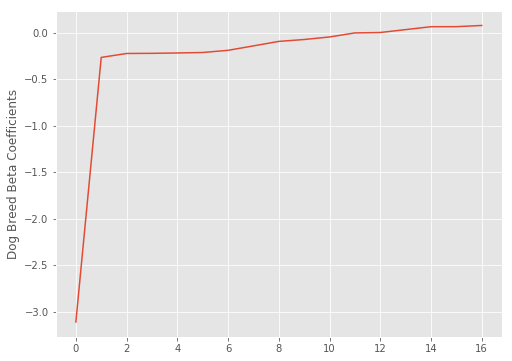

In [149]:
# plot the coefficients in the model

plt.rcParams["figure.figsize"] = (8,6)
beta = np.sort(dogbreed_lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Dog Breed Beta Coefficients')

Text(0, 0.5, 'TPR')

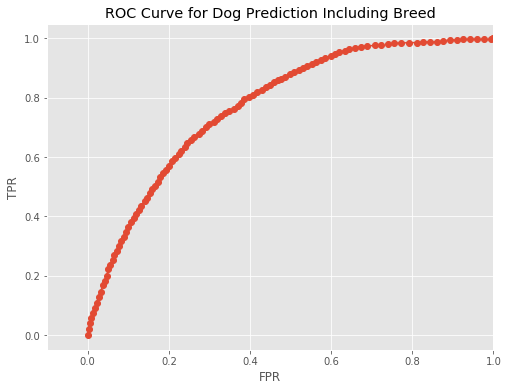

In [150]:
# plot the ROC curve

dogbreed_summary = dogbreed_lrModel.summary
dogbreed_roc = dogbreed_summary.roc.toPandas()
plt.rcParams["figure.figsize"] = (8,6)
dogbreed_roc.plot(x='FPR', y='TPR', xlim = [-0.1, 1], style='--o', legend=False)
plt.title('ROC Curve for Dog Prediction Including Breed')
plt.ylabel('TPR')

In [151]:
# transform train and test data

dogbreed_fittedTrain = dogbreed_lrModel.transform(dogbreed_train)
dogbreed_fittedTest = dogbreed_lrModel.transform(dogbreed_test)

In [152]:
# AUC evaluator
dogbreed_lr_train_auc = aucEvaluator.evaluate(dogbreed_fittedTrain)
dogbreed_lr_test_auc = aucEvaluator.evaluate(dogbreed_fittedTest)

# accuracy evaluator
dogbreed_lr_train_acc = accEvaluator.evaluate(dogbreed_fittedTrain)
dogbreed_lr_test_acc = accEvaluator.evaluate(dogbreed_fittedTest)

# precision evaluator
dogbreed_lr_train_prc = prcEvaluator.evaluate(dogbreed_fittedTrain)
dogbreed_lr_test_prc = prcEvaluator.evaluate(dogbreed_fittedTest)

# recall evaluator
dogbreed_lr_train_rec = recEvaluator.evaluate(dogbreed_fittedTrain)
dogbreed_lr_test_rec = recEvaluator.evaluate(dogbreed_fittedTest)

# F1-score evaluator
dogbreed_lr_train_f1 = f1Evaluator.evaluate(dogbreed_fittedTrain)
dogbreed_lr_test_f1 = f1Evaluator.evaluate(dogbreed_fittedTest)

In [153]:
# summarize model perfomance

dogbreed_lr_train_pfmc = [dogbreed_lr_train_auc, dogbreed_lr_train_acc, dogbreed_lr_train_prc,\
                          dogbreed_lr_train_rec, dogbreed_lr_train_f1]
dogbreed_lr_test_pfmc = [dogbreed_lr_test_auc, dogbreed_lr_test_acc, dogbreed_lr_test_prc,\
                         dogbreed_lr_test_rec, dogbreed_lr_test_f1]

dogbreed_lr_summary = pd.DataFrame(data=[dogbreed_lr_train_pfmc, dogbreed_lr_test_pfmc], columns=['AUC', 'Accuracy',\
                                'Precision', 'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('--------Dog Logreg with Breed Summary--------')
np.round(dogbreed_lr_summary,4)

--------Dog Logreg with Breed Summary--------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.7769,0.6987,0.7129,0.6987,0.697
Test Set,0.7823,0.7170,0.7328,0.7170,0.715


### 6.4.2 Dog Prediction Comparison

We then compare the result with the one without breed information.

In [154]:
# train another logreg model using the new dataset without breed information

df_dog_without_breed = df_dog_with_breed.select("age", "is_sc", "sex", "reproduction", "quarter", "is_wkd" , "outcome_type")
dogwithoutbreed_reg_result = RF2.fit(df_dog_without_breed).transform(df_dog_without_breed)

dogwithoutbreed_train, dogwithoutbreed_test = dogwithoutbreed_reg_result.randomSplit([0.7, 0.3], seed=843)
dogwithoutbreed_lr = LogisticRegression()
dogwithoutbreed_lrModel = dogwithoutbreed_lr.fit(dogwithoutbreed_train)

In [155]:
# transform train and test data

dogwithoutbreed_fittedTrain = dogwithoutbreed_lrModel.transform(dogwithoutbreed_train)
dogwithoutbreed_fittedTest = dogwithoutbreed_lrModel.transform(dogwithoutbreed_test)

In [156]:
# AUC evaluator
dogwithoutbreed_lr_train_auc = aucEvaluator.evaluate(dogwithoutbreed_fittedTrain)
dogwithoutbreed_lr_test_auc = aucEvaluator.evaluate(dogwithoutbreed_fittedTest)

# accuracy evaluator
dogwithoutbreed_lr_train_acc = accEvaluator.evaluate(dogwithoutbreed_fittedTrain)
dogwithoutbreed_lr_test_acc = accEvaluator.evaluate(dogwithoutbreed_fittedTest)

# precision evaluator
dogwithoutbreed_lr_train_prc = prcEvaluator.evaluate(dogwithoutbreed_fittedTrain)
dogwithoutbreed_lr_test_prc = prcEvaluator.evaluate(dogwithoutbreed_fittedTest)

# recall evaluator
dogwithoutbreed_lr_train_rec = recEvaluator.evaluate(dogwithoutbreed_fittedTrain)
dogwithoutbreed_lr_test_rec = recEvaluator.evaluate(dogwithoutbreed_fittedTest)

# F1-score evaluator
dogwithoutbreed_lr_train_f1 = f1Evaluator.evaluate(dogwithoutbreed_fittedTrain)
dogwithoutbreed_lr_test_f1 = f1Evaluator.evaluate(dogwithoutbreed_fittedTest)

In [157]:
# summarize model perfomance

dogwithoutbreed_lr_train_pfmc = [dogwithoutbreed_lr_train_auc, dogwithoutbreed_lr_train_acc, dogwithoutbreed_lr_train_prc,\
                          dogwithoutbreed_lr_train_rec, dogwithoutbreed_lr_train_f1]
dogwithoutbreed_lr_test_pfmc = [dogwithoutbreed_lr_test_auc, dogwithoutbreed_lr_test_acc, dogwithoutbreed_lr_test_prc,\
                         dogwithoutbreed_lr_test_rec, dogwithoutbreed_lr_test_f1]

dogwithoutbreed_lr_summary = pd.DataFrame(data=[dogwithoutbreed_lr_train_pfmc, dogwithoutbreed_lr_test_pfmc], columns=['AUC',\
                                        'Accuracy','Precision', 'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('-------Dog Logreg without Breed Summary-------')
np.round(dogwithoutbreed_lr_summary,4)

-------Dog Logreg without Breed Summary-------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.7786,0.6993,0.7169,0.6993,0.6969
Test Set,0.7699,0.7065,0.7256,0.7065,0.7038


In [158]:
# overall summary and comparison w/o breed information

dog_breed_lr_train_diff = [x - y for x, y in zip(dogbreed_lr_train_pfmc, dogwithoutbreed_lr_train_pfmc)]
dog_breed_lr_test_diff = [x - y for x, y in zip(dogbreed_lr_test_pfmc, dogwithoutbreed_lr_test_pfmc)]

dog_breed_lr_train_diff_rate = list((np.divide(dog_breed_lr_train_diff, dogwithoutbreed_lr_train_pfmc))*100)
dog_breed_lr_test_diff_rate = list((np.divide(dog_breed_lr_test_diff, dogwithoutbreed_lr_test_pfmc))*100)

dog_breed_lr_train_compare = pd.DataFrame(data=[dogbreed_lr_train_pfmc, dogwithoutbreed_lr_train_pfmc,\
                      dog_breed_lr_train_diff, dog_breed_lr_train_diff_rate], columns=['AUC', 'Accuracy','Precision',\
                      'Recall', 'F1'], index=['With breed', 'W/o breed', 'Improvement', 'Imprvmt rate (%)'])

dog_breed_lr_test_compare = pd.DataFrame(data=[dogbreed_lr_test_pfmc, dogwithoutbreed_lr_test_pfmc,\
                      dog_breed_lr_test_diff, dog_breed_lr_test_diff_rate], columns=['AUC', 'Accuracy','Precision',\
                      'Recall', 'F1'], index=['With breed', 'W/o breed', 'Improvement', 'Imprvmt rate (%)'])

In [159]:
print('----Comparison: Dog Logreg w/o Breed, Train set----')
np.round(dog_breed_lr_train_compare,4)

----Comparison: Dog Logreg w/o Breed, Train set----


,AUC,Accuracy,Precision,Recall,F1
With breed,0.7769,0.6987,0.7129,0.6987,0.6970
W/o breed,0.7786,0.6993,0.7169,0.6993,0.6969
Improvement,-0.0017,-0.0007,-0.0040,-0.0007,0.0001
Imprvmt rate (%),-0.2202,-0.0931,-0.5598,-0.0931,0.0175


In [160]:
print('----Comparison: Dog Logreg w/o Breed, Test set----')
np.round(dog_breed_lr_test_compare,4)

----Comparison: Dog Logreg w/o Breed, Test set----


,AUC,Accuracy,Precision,Recall,F1
With breed,0.7823,0.7170,0.7328,0.7170,0.7150
W/o breed,0.7699,0.7065,0.7256,0.7065,0.7038
Improvement,0.0123,0.0105,0.0071,0.0105,0.0112
Imprvmt rate (%),1.6013,1.4819,0.9806,1.4819,1.5973


We see that with breed information, the train set outcomes hardly change, but test set shows significantly better performance. We could say that breed information helps.

### 6.4.3 Cat Prediction with breed

In [161]:
catbreed_train, catbreed_test = catbreed_reg_result.randomSplit([0.7, 0.3], seed=843)
catbreed_lr = LogisticRegression()
catbreed_lrModel = catbreed_lr.fit(catbreed_train)

Text(0, 0.5, 'Cat Breed Beta Coefficients')

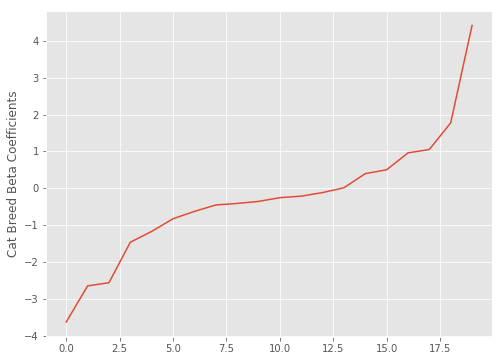

In [162]:
# plot the coefficients in the model

plt.rcParams["figure.figsize"] = (8,6)
beta = np.sort(catbreed_lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Cat Breed Beta Coefficients')

Text(0, 0.5, 'TPR')

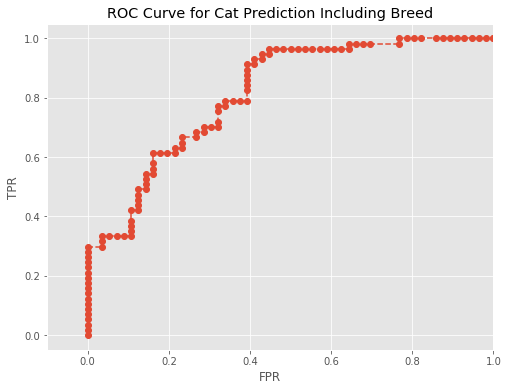

In [163]:
# plot the ROC curve

catbreed_summary = catbreed_lrModel.summary
catbreed_roc = catbreed_summary.roc.toPandas()
plt.rcParams["figure.figsize"] = (8,6)
catbreed_roc.plot(x='FPR', y='TPR', xlim = [-0.1, 1], style='--o', legend=False)
plt.title('ROC Curve for Cat Prediction Including Breed')
plt.ylabel('TPR')

In [164]:
# transform train and test data

catbreed_fittedTrain = catbreed_lrModel.transform(catbreed_train)
catbreed_fittedTest = catbreed_lrModel.transform(catbreed_test)

In [165]:
# AUC evaluator
catbreed_lr_train_auc = aucEvaluator.evaluate(catbreed_fittedTrain)
catbreed_lr_test_auc = aucEvaluator.evaluate(catbreed_fittedTest)

# accuracy evaluator
catbreed_lr_train_acc = accEvaluator.evaluate(catbreed_fittedTrain)
catbreed_lr_test_acc = accEvaluator.evaluate(catbreed_fittedTest)

# precision evaluator
catbreed_lr_train_prc = prcEvaluator.evaluate(catbreed_fittedTrain)
catbreed_lr_test_prc = prcEvaluator.evaluate(catbreed_fittedTest)

# recall evaluator
catbreed_lr_train_rec = recEvaluator.evaluate(catbreed_fittedTrain)
catbreed_lr_test_rec = recEvaluator.evaluate(catbreed_fittedTest)

# F1-score evaluator
catbreed_lr_train_f1 = f1Evaluator.evaluate(catbreed_fittedTrain)
catbreed_lr_test_f1 = f1Evaluator.evaluate(catbreed_fittedTest)

In [166]:
# summarize model perfomance

catbreed_lr_train_pfmc = [catbreed_lr_train_auc, catbreed_lr_train_acc, catbreed_lr_train_prc,\
                          catbreed_lr_train_rec, catbreed_lr_train_f1]
catbreed_lr_test_pfmc = [catbreed_lr_test_auc, catbreed_lr_test_acc, catbreed_lr_test_prc,\
                         catbreed_lr_test_rec, catbreed_lr_test_f1]

catbreed_lr_summary = pd.DataFrame(data=[catbreed_lr_train_pfmc, catbreed_lr_test_pfmc], columns=['AUC', 'Accuracy',\
                                'Precision', 'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('--------Cat Logreg with Breed Summary--------')
np.round(catbreed_lr_summary,4)

--------Cat Logreg with Breed Summary--------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.8161,0.7522,0.7736,0.7522,0.7468
Test Set,0.7008,0.6250,0.6272,0.6250,0.6257


### 6.4.4 Cat Prediction Comparison

In [167]:
# train another logreg model using the new dataset without breed information

df_cat_without_breed = df_cat_with_breed.select("age", "is_sc", "sex", "reproduction", "quarter", "is_wkd" , "outcome_type")
catwithoutbreed_reg_result = RF2.fit(df_cat_without_breed).transform(df_cat_without_breed)

catwithoutbreed_train, catwithoutbreed_test = catwithoutbreed_reg_result.randomSplit([0.7, 0.3], seed=843)
catwithoutbreed_lr = LogisticRegression()
catwithoutbreed_lrModel = catwithoutbreed_lr.fit(catwithoutbreed_train)

In [168]:
# transform train and test data

catwithoutbreed_fittedTrain = catwithoutbreed_lrModel.transform(catwithoutbreed_train)
catwithoutbreed_fittedTest = catwithoutbreed_lrModel.transform(catwithoutbreed_test)

In [169]:
# AUC evaluator
catwithoutbreed_lr_train_auc = aucEvaluator.evaluate(catwithoutbreed_fittedTrain)
catwithoutbreed_lr_test_auc = aucEvaluator.evaluate(catwithoutbreed_fittedTest)

# accuracy evaluator
catwithoutbreed_lr_train_acc = accEvaluator.evaluate(catwithoutbreed_fittedTrain)
catwithoutbreed_lr_test_acc = accEvaluator.evaluate(catwithoutbreed_fittedTest)

# precision evaluator
catwithoutbreed_lr_train_prc = prcEvaluator.evaluate(catwithoutbreed_fittedTrain)
catwithoutbreed_lr_test_prc = prcEvaluator.evaluate(catwithoutbreed_fittedTest)

# recall evaluator
catwithoutbreed_lr_train_rec = recEvaluator.evaluate(catwithoutbreed_fittedTrain)
catwithoutbreed_lr_test_rec = recEvaluator.evaluate(catwithoutbreed_fittedTest)

# F1-score evaluator
catwithoutbreed_lr_train_f1 = f1Evaluator.evaluate(catwithoutbreed_fittedTrain)
catwithoutbreed_lr_test_f1 = f1Evaluator.evaluate(catwithoutbreed_fittedTest)

In [170]:
# summarize model perfomance

catwithoutbreed_lr_train_pfmc = [catwithoutbreed_lr_train_auc, catwithoutbreed_lr_train_acc, catwithoutbreed_lr_train_prc,\
                          catwithoutbreed_lr_train_rec, catwithoutbreed_lr_train_f1]
catwithoutbreed_lr_test_pfmc = [catwithoutbreed_lr_test_auc, catwithoutbreed_lr_test_acc, catwithoutbreed_lr_test_prc,\
                         catwithoutbreed_lr_test_rec, catwithoutbreed_lr_test_f1]

catwithoutbreed_lr_summary = pd.DataFrame(data=[catwithoutbreed_lr_train_pfmc, catwithoutbreed_lr_test_pfmc], columns=['AUC',\
                                        'Accuracy','Precision', 'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('-------Cat Logreg without Breed Summary-------')
np.round(catwithoutbreed_lr_summary,4)

-------Cat Logreg without Breed Summary-------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.7690,0.6903,0.7136,0.6903,0.6807
Test Set,0.7563,0.7000,0.6990,0.7000,0.6977


In [171]:
# overall summary and comparison w/o breed information

cat_breed_lr_train_diff = [x - y for x, y in zip(catbreed_lr_train_pfmc, catwithoutbreed_lr_train_pfmc)]
cat_breed_lr_test_diff = [x - y for x, y in zip(catbreed_lr_test_pfmc, catwithoutbreed_lr_test_pfmc)]

cat_breed_lr_train_diff_rate = list((np.divide(cat_breed_lr_train_diff, catwithoutbreed_lr_train_pfmc))*100)
cat_breed_lr_test_diff_rate = list((np.divide(cat_breed_lr_test_diff, catwithoutbreed_lr_test_pfmc))*100)

cat_breed_lr_train_compare = pd.DataFrame(data=[catbreed_lr_train_pfmc, catwithoutbreed_lr_train_pfmc,\
                      cat_breed_lr_train_diff, cat_breed_lr_train_diff_rate], columns=['AUC', 'Accuracy','Precision',\
                      'Recall', 'F1'], index=['With breed', 'W/o breed', 'Improvement', 'Imprvmt rate (%)'])

cat_breed_lr_test_compare = pd.DataFrame(data=[catbreed_lr_test_pfmc, catwithoutbreed_lr_test_pfmc,\
                      cat_breed_lr_test_diff, cat_breed_lr_test_diff_rate], columns=['AUC', 'Accuracy','Precision',\
                      'Recall', 'F1'], index=['With breed', 'W/o breed', 'Improvement', 'Imprvmt rate (%)'])

In [172]:
print('----Comparison: Cat Logreg w/o Breed, Train set----')
np.round(cat_breed_lr_train_compare,4)

----Comparison: Cat Logreg w/o Breed, Train set----


,AUC,Accuracy,Precision,Recall,F1
With breed,0.8161,0.7522,0.7736,0.7522,0.7468
W/o breed,0.7690,0.6903,0.7136,0.6903,0.6807
Improvement,0.0471,0.0619,0.0600,0.0619,0.0661
Imprvmt rate (%),6.1316,8.9744,8.4076,8.9744,9.7043


In [173]:
print('----Comparison: Cat Logreg w/o Breed, Test set----')
np.round(cat_breed_lr_test_compare,4)

----Comparison: Cat Logreg w/o Breed, Test set----


,AUC,Accuracy,Precision,Recall,F1
With breed,0.7008,0.6250,0.6272,0.6250,0.6257
W/o breed,0.7563,0.7000,0.6990,0.7000,0.6977
Improvement,-0.0556,-0.0750,-0.0718,-0.0750,-0.0720
Imprvmt rate (%),-7.3456,-10.7143,-10.2675,-10.7143,-10.3184


We see that for cat prediction, additional features lead to train sample overfitting: we get 0.82 (train) and 0.70 (test) AUC with these features, and 0.77 (train) and 0.76 (test) without them. Therefore, it's not a good choice to include additional features for cats.

# 7. Pipeline and hyperparameter tuning

In [174]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

## 7.1 Pipeline and model tuing for Logistic Regression

In [175]:
# set up pipeline stages
rForm_lr = RFormula(featuresCol="features_lr")
lr = LogisticRegression().setLabelCol("label").setFeaturesCol("features_lr")
stages_lr = [rForm_lr, lr]
pipeline_lr = Pipeline().setStages(stages_lr)

# build grids for hyperparameters: RFormula, elasticNetParam, regParam
params_lr = ParamGridBuilder()\
  .addGrid(rForm_lr.formula, [
    "outcome_type ~ .",
    "outcome_type ~ . + age:is_sc",
    "outcome_type ~ . + age:is_sc + sex:is_sc",
    "outcome_type ~ . + age:is_sc + sex:is_sc+ reproduction:is_wkd"
    ])\
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .addGrid(lr.regParam, [0.0, 0.01, 0.1, 1.0])\
  .build()

In [176]:
# optimal model selection: the one with highest AUC

lr_tvs = TrainValidationSplit()\
  .setTrainRatio(0.7)\
  .setEstimatorParamMaps(params_lr)\
  .setEstimator(pipeline_lr)\
  .setEvaluator(aucEvaluator)

### 7.1.1 Dog prediction

In [177]:
# split dog sample data, fit the estimator, and transform train and test data

dog_ppl_train, dog_ppl_test = df_dog_fct.randomSplit([0.7, 0.3], seed=843)
dog_lr_fitted = lr_tvs.fit(dog_ppl_train)
dog_ppl_fittedTrain = dog_lr_fitted.transform(dog_train)
dog_ppl_fittedTest = dog_lr_fitted.transform(dog_test)

In [178]:
# AUC evaluator
dog_opt_lr_train_auc = aucEvaluator.evaluate(dog_ppl_fittedTrain)
dog_opt_lr_test_auc = aucEvaluator.evaluate(dog_ppl_fittedTest)

# accuracy evaluator
dog_opt_lr_train_acc = accEvaluator.evaluate(dog_ppl_fittedTrain)
dog_opt_lr_test_acc = accEvaluator.evaluate(dog_ppl_fittedTest)

# precision evaluator
dog_opt_lr_train_prc = prcEvaluator.evaluate(dog_ppl_fittedTrain)
dog_opt_lr_test_prc = prcEvaluator.evaluate(dog_ppl_fittedTest)

# recall evaluator
dog_opt_lr_train_rec = recEvaluator.evaluate(dog_ppl_fittedTrain)
dog_opt_lr_test_rec = recEvaluator.evaluate(dog_ppl_fittedTest)

# F1-score evaluator
dog_opt_lr_train_f1 = f1Evaluator.evaluate(dog_ppl_fittedTrain)
dog_opt_lr_test_f1 = f1Evaluator.evaluate(dog_ppl_fittedTest)

In [179]:
# summarize optimal model performance

dog_opt_lr_train_pfmc = [dog_opt_lr_train_auc, dog_opt_lr_train_acc, dog_opt_lr_train_prc,\
                         dog_opt_lr_train_rec, dog_opt_lr_train_f1]
dog_opt_lr_test_pfmc = [dog_opt_lr_test_auc, dog_opt_lr_test_acc, dog_opt_lr_test_prc, dog_opt_lr_test_rec, dog_opt_lr_test_f1]

dog_opt_lr_summary = pd.DataFrame(data=[dog_opt_lr_train_pfmc, dog_opt_lr_test_pfmc], columns=['AUC', 'Accuracy', 'Precision', \
                            'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('-------Dog Tuned Logreg Model summary-------')
np.round(dog_opt_lr_summary,4)

-------Dog Tuned Logreg Model summary-------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.7894,0.6990,0.7228,0.6990,0.6972
Test Set,0.7930,0.7074,0.7254,0.7074,0.7058


In [180]:
# get optimal model hyperparameters

dog_bestRF = dog_lr_fitted.bestModel.stages[0]._java_obj
dog_bestLR = dog_lr_fitted.bestModel.stages[-1]._java_obj

dog_rformLR = dog_bestRF.getFormula()
dog_elastLR = dog_bestLR.getElasticNetParam()
dog_regLR = dog_bestLR.getRegParam()

print("----------Hyperparameters in the best dog Logistic prediction model----------")
print("RFormula: {}".format(dog_rformLR))
print("elasticNetParam: {}".format(dog_elastLR))
print("regParam: {}".format(dog_regLR))

----------Hyperparameters in the best dog Logistic prediction model----------
RFormula: outcome_type ~ . + age:is_sc
elasticNetParam: 1.0
regParam: 0.01


In [181]:
# save model for future usage

dog_lr_fitted.bestModel.write().overwrite().save(data + "model/dogModel_1")

In [182]:
# compare best model performance against the one with default hyperparameter values

dog_opt_lr_pfmc = [dog_opt_lr_train_acc, dog_opt_lr_test_acc, dog_opt_lr_train_auc, dog_opt_lr_test_auc,\
                   dog_opt_lr_train_f1, dog_opt_lr_test_f1]
dog_lr_diff = [x - y for x, y in zip(dog_opt_lr_pfmc, dog_lr_pfmc)]
dog_lr_diff_rate = list((np.divide(dog_lr_diff, dog_lr_pfmc))*100)
dog_lr_compare = pd.DataFrame(data=[dog_lr_pfmc, dog_opt_lr_pfmc, dog_lr_diff, dog_lr_diff_rate], columns=['Train accuracy',\
                             'Test accuracy', 'Train AUC', 'Test AUC', 'Train F1-score', 'Test F1-score'],\
                              index=['Logreg', 'Optimal Logreg', 'Improvement', 'Imprvmt rate (%)'])
print('------------------Dog prediction comparison: Tuned and default------------------')
np.round(dog_lr_compare, 4)

------------------Dog prediction comparison: Tuned and default------------------


,Train accuracy,Test accuracy,Train AUC,Test AUC,Train F1-score,Test F1-score
Logreg,0.6999,0.7078,0.7863,0.7898,0.6987,0.7066
Optimal Logreg,0.6990,0.7074,0.7894,0.7930,0.6972,0.7058
Improvement,-0.0009,-0.0004,0.0031,0.0032,-0.0015,-0.0008
Imprvmt rate (%),-0.1258,-0.0530,0.3927,0.4062,-0.2087,-0.1191


We see with change of `RFormula` from `outcome_type ~ .` to `outcome_type ~ . + age:is_sc`, `elasticNetParam` from 0.0 to 1.0,  `regParam` from 0.0 to 0.01, the model has better AUC but lower accuracy and F1-score. This is because we set `aucEvaluator` as metrics in the validation process. The improvement is small, about 0.4%.

### 7.1.2 Cat prediction

In [183]:
# split cat sample data, fit the estimator, and transform train and test data

cat_ppl_train, cat_ppl_test = df_cat_fct.randomSplit([0.7, 0.3], seed=843)
cat_lr_fitted = lr_tvs.fit(cat_ppl_train)
cat_ppl_fittedTrain = cat_lr_fitted.transform(cat_train)
cat_ppl_fittedTest = cat_lr_fitted.transform(cat_test)

In [184]:
# AUC estimator
cat_opt_lr_train_auc = aucEvaluator.evaluate(cat_ppl_fittedTrain)
cat_opt_lr_test_auc = aucEvaluator.evaluate(cat_ppl_fittedTest)

# accuracy estimator
cat_opt_lr_train_acc = accEvaluator.evaluate(cat_ppl_fittedTrain)
cat_opt_lr_test_acc = accEvaluator.evaluate(cat_ppl_fittedTest)

# precision evaluator
cat_opt_lr_train_prc = prcEvaluator.evaluate(cat_ppl_fittedTrain)
cat_opt_lr_test_prc = prcEvaluator.evaluate(cat_ppl_fittedTest)

# recall evaluator
cat_opt_lr_train_rec = recEvaluator.evaluate(cat_ppl_fittedTrain)
cat_opt_lr_test_rec = recEvaluator.evaluate(cat_ppl_fittedTest)

# F1-score evaluator
cat_opt_lr_train_f1 = f1Evaluator.evaluate(cat_ppl_fittedTrain)
cat_opt_lr_test_f1 = f1Evaluator.evaluate(cat_ppl_fittedTest)

In [185]:
# summarize optimal model performance

cat_opt_lr_train_pfmc = [cat_opt_lr_train_auc, cat_opt_lr_train_acc, cat_opt_lr_train_prc,\
                         cat_opt_lr_train_rec, cat_opt_lr_train_f1]
cat_opt_lr_test_pfmc = [cat_opt_lr_test_auc, cat_opt_lr_test_acc, cat_opt_lr_test_prc, cat_opt_lr_test_rec, cat_opt_lr_test_f1]

cat_opt_lr_summary = pd.DataFrame(data=[cat_opt_lr_train_pfmc, cat_opt_lr_test_pfmc], columns=['AUC', 'Accuracy', 'Precision',\
                            'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('-------Cat Tuned Logreg Model summary-------')
np.round(cat_opt_lr_summary,4)

-------Cat Tuned Logreg Model summary-------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.8761,0.7701,0.8049,0.7701,0.7657
Test Set,0.8792,0.7724,0.8063,0.7724,0.7691


In [186]:
# get optimal model hyperparameters

cat_bestRF = cat_lr_fitted.bestModel.stages[0]._java_obj
cat_bestLR = cat_lr_fitted.bestModel.stages[-1]._java_obj

cat_rformLR = cat_bestRF.getFormula()
cat_elastLR = cat_bestLR.getElasticNetParam()
cat_regLR = cat_bestLR.getRegParam()

print("----------Hyperparameters in the best cat Logistic prediction model----------")
print("RFormula: {}".format(cat_rformLR))
print("elasticNetParam: {}".format(cat_elastLR))
print("regParam: {}".format(cat_regLR))

----------Hyperparameters in the best cat Logistic prediction model----------
RFormula: outcome_type ~ . + age:is_sc + sex:is_sc+ reproduction:is_wkd
elasticNetParam: 0.5
regParam: 0.1


In [187]:
# save model for future usage

cat_lr_fitted.bestModel.write().overwrite().save(data + "model/catModel_1")

In [188]:
# compare best model performance against the one with default hyperparameter values

cat_opt_lr_pfmc = [cat_opt_lr_train_acc, cat_opt_lr_test_acc, cat_opt_lr_train_auc, cat_opt_lr_test_auc,\
                   cat_opt_lr_train_f1, cat_opt_lr_test_f1]
cat_lr_diff = [x - y for x, y in zip(cat_opt_lr_pfmc, cat_lr_pfmc)]
cat_lr_diff_rate = list((np.divide(cat_lr_diff, cat_lr_pfmc))*100)
cat_lr_compare = pd.DataFrame(data=[cat_lr_pfmc, cat_opt_lr_pfmc, cat_lr_diff, cat_lr_diff_rate], columns=['Train accuracy',\
                            'Test accuracy', 'Train AUC', 'Test AUC', 'Train F1-score', 'Test F1-score'],\
                             index=['Logreg', 'Optimal Logreg', 'Improvement', 'Imprvmt rate (%)'])
print('------------------Cat prediction comparison: Tuned and default------------------')
np.round(cat_lr_compare, 4)

------------------Cat prediction comparison: Tuned and default------------------


,Train accuracy,Test accuracy,Train AUC,Test AUC,Train F1-score,Test F1-score
Logreg,0.7744,0.7821,0.8586,0.8633,0.7731,0.7814
Optimal Logreg,0.7701,0.7724,0.8761,0.8792,0.7657,0.7691
Improvement,-0.0044,-0.0097,0.0174,0.0159,-0.0074,-0.0123
Imprvmt rate (%),-0.5630,-1.2342,2.0319,1.8434,-0.9568,-1.5726


Similarly, the optimal model selected by pipeline has a higher AUC but lower accuracy and F1-score. With change of `RFormula` from `outcome ~ .` to `outcome ~ . + age:is_sc + sex:is_sc+ reproduction:is_wkd`, `elasticNetParam` from 0.0 to 0.5, `regParam` from 0.0 to 0.1, AUC has an apparent increase of 2.03% and 1.84% in train and test sets respectively.

## 7.2 Model tuning for Multilayer Perceptron Classifier

For Multilayer Perceptron Classifier, since the number of nodes in the input layer must match feature numbers, we could only use the default formula `outcome ~ .` in feature transformation. Therefore, there's no need to redo feature transformation part for MPC, and we just use `ParamGridBuilder` to find optimal hyperparameters.

In [189]:
# set up a new multilayer merceptron mlassifier for hyperparam tuning
mpcTune = MultilayerPerceptronClassifier(layers=[8,5,5,2], blockSize=128, seed=843)

# build grids for hyperparameters: layers, solver
params_mpc = ParamGridBuilder()\
  .addGrid(mpc.layers, [[8,3,3,2],[8,5,5,2],[8,10,10,2],[8,5,5,5,2],[8,3,3,3,2]])\
  .addGrid(mpc.solver, ['l-bfgs', 'gd'])\
  .build()

In [190]:
# optimal model selection: the one with highest AUC

mpc_tvs = TrainValidationSplit()\
  .setTrainRatio(0.7)\
  .setEstimatorParamMaps(params_mpc)\
  .setEstimator(mpcTune)\
  .setEvaluator(aucEvaluator)

### 7.2.1 Dog prediction

In [191]:
# fit the estimator, and transform train and test data

dog_mpc_fitted = mpc_tvs.fit(dog_train)
dog_ppl_fittedTrainMPC = dog_mpc_fitted.transform(dog_train)
dog_ppl_fittedTestMPC = dog_mpc_fitted.transform(dog_test)

In [192]:
# AUC evaluator
dog_opt_mpc_train_auc = aucEvaluator.evaluate(dog_ppl_fittedTrainMPC)
dog_opt_mpc_test_auc = aucEvaluator.evaluate(dog_ppl_fittedTestMPC)

# accuracy evaluator
dog_opt_mpc_train_acc = accEvaluator.evaluate(dog_ppl_fittedTrainMPC)
dog_opt_mpc_test_acc = accEvaluator.evaluate(dog_ppl_fittedTestMPC)

# precision evaluator
dog_opt_mpc_train_prc = prcEvaluator.evaluate(dog_ppl_fittedTrainMPC)
dog_opt_mpc_test_prc = prcEvaluator.evaluate(dog_ppl_fittedTestMPC)

# recall evaluator
dog_opt_mpc_train_rec = recEvaluator.evaluate(dog_ppl_fittedTrainMPC)
dog_opt_mpc_test_rec = recEvaluator.evaluate(dog_ppl_fittedTestMPC)

# F1-score evaluator
dog_opt_mpc_train_f1 = f1Evaluator.evaluate(dog_ppl_fittedTrainMPC)
dog_opt_mpc_test_f1 = f1Evaluator.evaluate(dog_ppl_fittedTestMPC)

In [193]:
# evaluate model performance

dog_opt_mpc_train_pfmc = [dog_opt_mpc_train_auc, dog_opt_mpc_train_acc, dog_opt_mpc_train_prc,\
                         dog_opt_mpc_train_rec, dog_opt_mpc_train_f1]
dog_opt_mpc_test_pfmc = [dog_opt_mpc_test_auc, dog_opt_mpc_test_acc, dog_opt_mpc_test_prc,\
                         dog_opt_mpc_test_rec, dog_opt_mpc_test_f1]

dog_opt_mpc_summary = pd.DataFrame(data=[dog_opt_mpc_train_pfmc, dog_opt_mpc_test_pfmc], columns=['AUC', 'Accuracy',\
                                    'Precision', 'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('--------Dog Tuned MPC Model summary--------')
np.round(dog_opt_mpc_summary,4)

--------Dog Tuned MPC Model summary--------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.7936,0.7114,0.7129,0.7114,0.7118
Test Set,0.7956,0.7139,0.7145,0.7139,0.7141


In [194]:
# get optimal model hyperparameters

dog_bestMPC = dog_mpc_fitted.bestModel

dog_layerMPC = dog_bestMPC.layers
dog_solverMPC = dog_bestMPC._java_obj.parent().getSolver()

print("----------Hyperparameters in the best dog prediction model: MPC Pipeline----------")
print("layers: {}".format(dog_layerMPC))
print("solver: {}".format(dog_solverMPC))

----------Hyperparameters in the best dog prediction model: MPC Pipeline----------
layers: [8, 5, 5, 2]
solver: l-bfgs


In [195]:
# save model for future usage

dog_mpc_fitted.bestModel.write().overwrite().save(data + "model/dogModel_2")

In [196]:
# compare best model performance against the one with default hyperparameter values

dog_opt_mpc_pfmc = [dog_opt_mpc_train_acc, dog_opt_mpc_test_acc, dog_opt_mpc_train_auc,\
                    dog_opt_mpc_test_auc, dog_opt_mpc_train_f1, dog_opt_mpc_test_f1]
dog_mpc_diff = [x - y for x, y in zip(dog_opt_mpc_pfmc, dog_mpc_pfmc)]
dog_mpc_diff_rate = list((np.divide(dog_mpc_diff, dog_mpc_pfmc))*100)
dog_mpc_compare = pd.DataFrame(data=[dog_mpc_pfmc, dog_opt_mpc_pfmc, dog_mpc_diff, dog_mpc_diff_rate],\
                    columns=['Train accuracy','Test accuracy', 'Train AUC', 'Test AUC', 'Train F1-score',\
                    'Test F1-score'], index=['MPC', 'Optimal MPC', 'Improvement', 'Imprvmt rate (%)'])
print('------------------Dog prediction comparison: Tuned and default------------------')
np.round(dog_mpc_compare, 4)

------------------Dog prediction comparison: Tuned and default------------------


,Train accuracy,Test accuracy,Train AUC,Test AUC,Train F1-score,Test F1-score
MPC,0.7116,0.7141,0.7937,0.7957,0.7120,0.7143
Optimal MPC,0.7114,0.7139,0.7936,0.7956,0.7118,0.7141
Improvement,-0.0002,-0.0002,-0.0000,-0.0000,-0.0002,-0.0001
Imprvmt rate (%),-0.0275,-0.0210,-0.0016,-0.0043,-0.0256,-0.0194


Since the default parameters in this model are exactly `layers` = [8, 5, 5, 2], and `solver` = l-bfgs, the tuned model shows no improvement at all. The 10^-4 level difference may come from calculation error. The original model is already the best model within pre-defined grids.

### 7.2.2 Cat prediction

In [197]:
# fit the estimator, and transform train and test data

cat_mpc_fitted = mpc_tvs.fit(cat_train)
cat_ppl_fittedTrainMPC = cat_mpc_fitted.transform(cat_train)
cat_ppl_fittedTestMPC = cat_mpc_fitted.transform(cat_test)

In [198]:
# AUC evaluator
cat_opt_mpc_train_auc = aucEvaluator.evaluate(cat_ppl_fittedTrainMPC)
cat_opt_mpc_test_auc = aucEvaluator.evaluate(cat_ppl_fittedTestMPC)

# accuracy evaluator
cat_opt_mpc_train_acc = accEvaluator.evaluate(cat_ppl_fittedTrainMPC)
cat_opt_mpc_test_acc = accEvaluator.evaluate(cat_ppl_fittedTestMPC)

# precision evaluator
cat_opt_mpc_train_prc = prcEvaluator.evaluate(cat_ppl_fittedTrainMPC)
cat_opt_mpc_test_prc = prcEvaluator.evaluate(cat_ppl_fittedTestMPC)

# recall evaluator
cat_opt_mpc_train_rec = recEvaluator.evaluate(cat_ppl_fittedTrainMPC)
cat_opt_mpc_test_rec = recEvaluator.evaluate(cat_ppl_fittedTestMPC)

# F1-score evaluator
cat_opt_mpc_train_f1 = f1Evaluator.evaluate(cat_ppl_fittedTrainMPC)
cat_opt_mpc_test_f1 = f1Evaluator.evaluate(cat_ppl_fittedTestMPC)

In [199]:
# evaluate model performance

cat_opt_mpc_train_pfmc = [cat_opt_mpc_train_auc, cat_opt_mpc_train_acc, cat_opt_mpc_train_prc,\
                         cat_opt_mpc_train_rec, cat_opt_mpc_train_f1]
cat_opt_mpc_test_pfmc = [cat_opt_mpc_test_auc, cat_opt_mpc_test_acc, cat_opt_mpc_test_prc,\
                         cat_opt_mpc_test_rec, cat_opt_mpc_test_f1]

cat_opt_mpc_summary = pd.DataFrame(data=[cat_opt_mpc_train_pfmc, cat_opt_mpc_test_pfmc], columns=['AUC', 'Accuracy',\
                                    'Precision', 'Recall', 'F1'], index=['Train Set', 'Test Set'])
print('--------Cat Tuned MPC Model summary--------')
np.round(cat_opt_mpc_summary,4)

--------Cat Tuned MPC Model summary--------


,AUC,Accuracy,Precision,Recall,F1
Train Set,0.8920,0.8088,0.8101,0.8088,0.8081
Test Set,0.8914,0.8104,0.8112,0.8104,0.8097


In [200]:
# get optimal model hyperparameters

cat_bestMPC = cat_mpc_fitted.bestModel

cat_layerMPC = cat_bestMPC.layers
cat_solverMPC = cat_bestMPC._java_obj.parent().getSolver()

print("----------Hyperparameters in the best cat MPC prediction model----------")
print("layers: {}".format(cat_layerMPC))
print("solver: {}".format(cat_solverMPC))

----------Hyperparameters in the best cat MPC prediction model----------
layers: [8, 5, 5, 2]
solver: l-bfgs


In [201]:
# save model for future usage

cat_mpc_fitted.bestModel.write().overwrite().save(data + "model/catModel_2")

In [202]:
# compare best model performance against the one with default hyperparameter values

cat_opt_mpc_pfmc = [cat_opt_mpc_train_acc, cat_opt_mpc_test_acc, cat_opt_mpc_train_auc,\
                    cat_opt_mpc_test_auc, cat_opt_mpc_train_f1, cat_opt_mpc_test_f1]
cat_mpc_diff = [x - y for x, y in zip(cat_opt_mpc_pfmc, cat_mpc_pfmc)]
cat_mpc_diff_rate = list((np.divide(cat_mpc_diff, cat_mpc_pfmc))*100)
cat_mpc_compare = pd.DataFrame(data=[cat_mpc_pfmc, cat_opt_mpc_pfmc, cat_mpc_diff, cat_mpc_diff_rate],\
                    columns=['Train accuracy','Test accuracy', 'Train AUC', 'Test AUC', 'Train F1-score', 'Test F1-score'],\
                    index=['MPC', 'Optimal MPC', 'Improvement', 'Imprvmt rate (%)'])
print('------------------Cat prediction comparison: Tuned and default------------------')
np.round(cat_mpc_compare, 4)

------------------Cat prediction comparison: Tuned and default------------------


,Train accuracy,Test accuracy,Train AUC,Test AUC,Train F1-score,Test F1-score
MPC,0.8088,0.8104,0.8920,0.8914,0.8081,0.8097
Optimal MPC,0.8088,0.8104,0.8920,0.8914,0.8081,0.8097
Improvement,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000
Imprvmt rate (%),0.0000,0.0000,0.0002,-0.0002,0.0000,0.0000


Similar to dogs, the tuned model for cats shows no improvement either. The original model is already the best model.

## 7.3 Pipeline and model tuning for Support Vector Machine

In [203]:
# set up pipeline stages
rForm_svm = RFormula(featuresCol="features_svm")
svmTune = LinearSVC(featuresCol="features_svm", maxIter=10)
stages_svm = [rForm_svm, svmTune]
pipeline_svm = Pipeline().setStages(stages_svm)

# build grids for hyperparameters: RFormula, elasticNetParam, regParam
params_svm = ParamGridBuilder()\
  .addGrid(rForm_svm.formula, [
    "outcome_type ~ .",
    "outcome_type ~ . + age:is_sc",
    "outcome_type ~ . + age:is_sc + sex:is_sc",
    ])\
  .addGrid(svmTune.maxIter, [10, 20, 50, 100])\
  .addGrid(svmTune.regParam, [0.0, 0.01, 0.1, 1.0])\
  .build()

In [204]:
# optimal model selection: the one with highest AUC

svm_tvs = TrainValidationSplit()\
  .setTrainRatio(0.7)\
  .setEstimatorParamMaps(params_svm)\
  .setEstimator(pipeline_svm)\
  .setEvaluator(aucEvaluator)

### 7.3.1 Dog prediction

In [205]:
# fit the estimator, and transform train and test data

dog_svm_fitted = svm_tvs.fit(dog_ppl_train)
dog_ppl_fittedTrainSVM = dog_svm_fitted.transform(dog_ppl_train)
dog_ppl_fittedTestSVM = dog_svm_fitted.transform(dog_ppl_test)

In [206]:
# AUC evaluator
dog_opt_svm_train_auc = aucEvaluator.evaluate(dog_ppl_fittedTrainSVM)
dog_opt_svm_test_auc = aucEvaluator.evaluate(dog_ppl_fittedTestSVM)

# accuracy evaluator
dog_opt_svm_train_acc = accEvaluator.evaluate(dog_ppl_fittedTrainSVM)
dog_opt_svm_test_acc = accEvaluator.evaluate(dog_ppl_fittedTestSVM)

# precision evaluator
dog_opt_svm_train_prc = prcEvaluator.evaluate(dog_ppl_fittedTrainSVM)
dog_opt_svm_test_prc = prcEvaluator.evaluate(dog_ppl_fittedTestSVM)

# recall evaluator
dog_opt_svm_train_rec = recEvaluator.evaluate(dog_ppl_fittedTrainSVM)
dog_opt_svm_test_rec = recEvaluator.evaluate(dog_ppl_fittedTestSVM)

# F1-score evaluator
dog_opt_svm_train_f1 = f1Evaluator.evaluate(dog_ppl_fittedTrainSVM)
dog_opt_svm_test_f1 = f1Evaluator.evaluate(dog_ppl_fittedTestSVM)

In [207]:
# evaluate model performance

dog_opt_svm_train_pfmc = [dog_opt_svm_train_auc, dog_opt_svm_train_acc, dog_opt_svm_train_prc,\
                         dog_opt_svm_train_rec, dog_opt_svm_train_f1]
dog_opt_svm_test_pfmc = [dog_opt_svm_test_auc, dog_opt_svm_test_acc, dog_opt_svm_test_prc,\
                         dog_opt_svm_test_rec, dog_opt_svm_test_f1]

dog_opt_svm_summary = pd.DataFrame(data=[dog_opt_svm_train_pfmc, dog_opt_svm_test_pfmc], columns=['AUC', 'accuracy',\
                                    'precision', 'recall', 'F1'], index=['train set', 'test set'])
print('--------Dog Tuned SVM Model summary--------')
np.round(dog_opt_svm_summary,4)

--------Dog Tuned SVM Model summary--------


,AUC,accuracy,precision,recall,F1
train set,0.7887,0.6826,0.7313,0.6826,0.6751
test set,0.7917,0.6915,0.7336,0.6915,0.6843


In [208]:
# get optimal model hyperparameters

dog_bestRFM = dog_svm_fitted.bestModel.stages[0]._java_obj
dog_bestSVM = dog_svm_fitted.bestModel.stages[-1]._java_obj

dog_rformSVM = dog_bestRFM.getFormula()
dog_maxIterSVM = dog_bestSVM.getMaxIter()
dog_regSVM = dog_bestSVM.getRegParam()

print("----------Hyperparameters in the best dog SVM prediction model----------")
print("RFormula: {}".format(dog_rformSVM))
print("maxIter: {}".format(dog_maxIterSVM))
print("regParam: {}".format(dog_regSVM))

----------Hyperparameters in the best dog SVM prediction model----------
RFormula: outcome_type ~ .
maxIter: 50
regParam: 0.1


In [209]:
# save model for future usage

dog_svm_fitted.bestModel.write().overwrite().save(data + "model/dogModel_3")

In [210]:
# compare best model performance against the one with default hyperparameter values

dog_opt_svm_pfmc = [dog_opt_svm_train_acc, dog_opt_svm_test_acc, dog_opt_svm_train_auc,\
                    dog_opt_svm_test_auc, dog_opt_svm_train_f1, dog_opt_svm_test_f1]
dog_svm_diff = [x - y for x, y in zip(dog_opt_svm_pfmc, dog_svm_pfmc)]
dog_svm_diff_rate = list((np.divide(dog_svm_diff, dog_svm_pfmc))*100)
dog_svm_compare = pd.DataFrame(data=[dog_svm_pfmc, dog_opt_svm_pfmc, dog_svm_diff, dog_svm_diff_rate],\
                    columns=['Train accuracy','Test accuracy', 'Train AUC', 'Test AUC', 'Train F1-score', 'Test F1-score'],\
                    index=['SVM', 'Optimal SVM', 'Improvement', 'Imprvmt rate (%)'])
print('------------------Dog prediction comparison: Tuned and default------------------')
np.round(dog_svm_compare, 4)

------------------Dog prediction comparison: Tuned and default------------------


,Train accuracy,Test accuracy,Train AUC,Test AUC,Train F1-score,Test F1-score
SVM,0.6935,0.6988,0.7612,0.7637,0.6933,0.6985
Optimal SVM,0.6826,0.6915,0.7887,0.7917,0.6751,0.6843
Improvement,-0.0108,-0.0073,0.0275,0.0280,-0.0182,-0.0142
Imprvmt rate (%),-1.5613,-1.0412,3.6086,3.6713,-2.6242,-2.0368


With change of `maxIter` from 10 to 50, and `regParam` from 0.0 to 0.1, AUC has an apparent increase of 3.61% in train set and 3.67% in test set.

### 7.3.2 Cat prediction

In [211]:
# fit the estimator, and transform train and test data

cat_svm_fitted = svm_tvs.fit(cat_ppl_train)
cat_ppl_fittedTrainSVM = cat_svm_fitted.transform(cat_ppl_train)
cat_ppl_fittedTestSVM = cat_svm_fitted.transform(cat_ppl_test)

In [212]:
# AUC evaluator
cat_opt_svm_train_auc = aucEvaluator.evaluate(cat_ppl_fittedTrainSVM)
cat_opt_svm_test_auc = aucEvaluator.evaluate(cat_ppl_fittedTestSVM)

# accuracy evaluator
cat_opt_svm_train_acc = accEvaluator.evaluate(cat_ppl_fittedTrainSVM)
cat_opt_svm_test_acc = accEvaluator.evaluate(cat_ppl_fittedTestSVM)

# precision evaluator
cat_opt_svm_train_prc = prcEvaluator.evaluate(cat_ppl_fittedTrainSVM)
cat_opt_svm_test_prc = prcEvaluator.evaluate(cat_ppl_fittedTestSVM)

# recall evaluator
cat_opt_svm_train_rec = recEvaluator.evaluate(cat_ppl_fittedTrainSVM)
cat_opt_svm_test_rec = recEvaluator.evaluate(cat_ppl_fittedTestSVM)

# F1-score evaluator
cat_opt_svm_train_f1 = f1Evaluator.evaluate(cat_ppl_fittedTrainSVM)
cat_opt_svm_test_f1 = f1Evaluator.evaluate(cat_ppl_fittedTestSVM)

In [213]:
# evaluate model performance

cat_opt_svm_train_pfmc = [cat_opt_svm_train_auc, cat_opt_svm_train_acc, cat_opt_svm_train_prc,\
                         cat_opt_svm_train_rec, cat_opt_svm_train_f1]
cat_opt_svm_test_pfmc = [cat_opt_svm_test_auc, cat_opt_svm_test_acc, cat_opt_svm_test_prc,\
                         cat_opt_svm_test_rec, cat_opt_svm_test_f1]

cat_opt_svm_summary = pd.DataFrame(data=[cat_opt_svm_train_pfmc, cat_opt_svm_test_pfmc], columns=['AUC', 'accuracy',\
                                    'precision', 'recall', 'F1'], index=['train set', 'test set'])
print('--------Cat Tuned SVM Model summary--------')
np.round(cat_opt_svm_summary,4)

--------Cat Tuned SVM Model summary--------


,AUC,accuracy,precision,recall,F1
train set,0.8740,0.7687,0.7948,0.7687,0.7656
test set,0.8781,0.7727,0.7984,0.7727,0.7705


In [214]:
# get optimal model hyperparameters

cat_bestRFM = cat_svm_fitted.bestModel.stages[0]._java_obj
cat_bestSVM = cat_svm_fitted.bestModel.stages[-1]._java_obj

cat_rformSVM = cat_bestRFM.getFormula()
cat_maxIterSVM = cat_bestSVM.getMaxIter()
cat_regSVM = cat_bestSVM.getRegParam()

print("----------Hyperparameters in the best cat SVM prediction model----------")
print("RFormula: {}".format(cat_rformSVM))
print("maxIter: {}".format(cat_maxIterSVM))
print("regParam: {}".format(cat_regSVM))

----------Hyperparameters in the best cat SVM prediction model----------
RFormula: outcome_type ~ . + age:is_sc + sex:is_sc
maxIter: 100
regParam: 0.1


In [215]:
# save model for future usage

cat_svm_fitted.bestModel.write().overwrite().save(data + "model/catModel_3")

In [216]:
# compare best model performance against the one with default hyperparameter values

cat_opt_svm_pfmc = [cat_opt_svm_train_acc, cat_opt_svm_test_acc, cat_opt_svm_train_auc,\
                    cat_opt_svm_test_auc, cat_opt_svm_train_f1, cat_opt_svm_test_f1]
cat_svm_diff = [x - y for x, y in zip(cat_opt_svm_pfmc, cat_svm_pfmc)]
cat_svm_diff_rate = list((np.divide(cat_svm_diff, cat_svm_pfmc))*100)
cat_svm_compare = pd.DataFrame(data=[cat_svm_pfmc, cat_opt_svm_pfmc, cat_svm_diff, cat_svm_diff_rate],\
                    columns=['Train accuracy','Test accuracy', 'Train AUC', 'Test AUC', 'Train F1-score', 'Test F1-score'],\
                    index=['SVM', 'Optimal SVM', 'Improvement', 'Imprvmt rate (%)'])
print('------------------Cat prediction comparison: Tuned and default------------------')
np.round(cat_svm_compare, 4)

------------------Cat prediction comparison: Tuned and default------------------


,Train accuracy,Test accuracy,Train AUC,Test AUC,Train F1-score,Test F1-score
SVM,0.7699,0.7758,0.8365,0.8403,0.7676,0.7743
Optimal SVM,0.7687,0.7727,0.8740,0.8781,0.7656,0.7705
Improvement,-0.0012,-0.0031,0.0374,0.0379,-0.0020,-0.0039
Imprvmt rate (%),-0.1589,-0.3988,4.4711,4.5088,-0.2599,-0.4981


With change of `RFormula` from `outcome ~ .` to `outcome_type ~ . + age:is_sc + sex:is_sc`, `maxIter` from 10 to 100, and `regParam` from 0.1 to 0.1, AUC has an apparent increase of 4.47% in train set and 4.51% in test set.

## 7.4 Summary and comparison of model performance

We make a summary of all tuned models' performance compared with default ones:

In [217]:
# dog prediction summary

dog_opt_lr_pfmc = [dog_lr_train_auc, dog_opt_lr_train_auc, (dog_opt_lr_train_auc-dog_lr_train_auc)/dog_lr_train_auc*100, \
                   dog_lr_test_auc, dog_opt_lr_test_auc, (dog_opt_lr_test_auc-dog_lr_test_auc)/dog_opt_lr_test_auc*100]
dog_opt_mpc_pfmc = [dog_mpc_train_auc, dog_opt_mpc_train_auc, (dog_opt_mpc_train_auc-dog_mpc_train_auc)/dog_mpc_train_auc,\
                    dog_mpc_test_auc, dog_opt_mpc_test_auc, (dog_opt_mpc_test_auc-dog_mpc_test_auc)/dog_mpc_test_auc]
dog_opt_svm_pfmc = [dog_svm_train_auc, dog_opt_svm_train_auc, (dog_opt_svm_train_auc-dog_svm_train_auc)/dog_svm_train_auc*100,\
                    dog_svm_test_auc, dog_opt_svm_test_auc, (dog_opt_svm_test_auc-dog_svm_test_auc)/dog_svm_test_auc*100]

dog_opt_model_summary = pd.DataFrame(data=[dog_opt_lr_pfmc, dog_opt_mpc_pfmc, dog_opt_svm_pfmc], columns=['Train AUC',\
                     'Tuned Train AUC', 'Train AUC Imprv Rate (%)', 'Test AUC', 'Tuned Test AUC', 'Test AUC Imprv Rate (%)'],\
                      index=['Logreg', 'MPC', 'SVM'])
print("--------------------------------------Dog model summary--------------------------------------")
np.round(dog_opt_model_summary,4)

--------------------------------------Dog model summary--------------------------------------


,Train AUC,Tuned Train AUC,Train AUC Imprv Rate (%),Test AUC,Tuned Test AUC,Test AUC Imprv Rate (%)
Logreg,0.7863,0.7894,0.3927,0.7898,0.7930,0.4045
MPC,0.7937,0.7936,-0.0000,0.7957,0.7956,-0.0000
SVM,0.7612,0.7887,3.6086,0.7637,0.7917,3.6713


Best improved model for dog prediction: **`Multilayer Perceptron Classifier`**

In [218]:
# cat prediction summary

cat_opt_lr_pfmc = [cat_lr_train_auc, cat_opt_lr_train_auc, (cat_opt_lr_train_auc-cat_lr_train_auc)/cat_lr_train_auc*100, \
                   cat_lr_test_auc, cat_opt_lr_test_auc, (cat_opt_lr_test_auc-cat_lr_test_auc)/cat_opt_lr_test_auc*100]
cat_opt_mpc_pfmc = [cat_mpc_train_auc, cat_opt_mpc_train_auc, (cat_opt_mpc_train_auc-cat_mpc_train_auc)/cat_mpc_train_auc,\
                    cat_mpc_test_auc, cat_opt_mpc_test_auc, (cat_opt_mpc_test_auc-cat_mpc_test_auc)/cat_mpc_test_auc]
cat_opt_svm_pfmc = [cat_svm_train_auc, cat_opt_svm_train_auc, (cat_opt_svm_train_auc-cat_svm_train_auc)/cat_svm_train_auc*100,\
                    cat_svm_test_auc, cat_opt_svm_test_auc, (cat_opt_svm_test_auc-cat_svm_test_auc)/cat_svm_test_auc*100]

cat_opt_model_summary = pd.DataFrame(data=[cat_opt_lr_pfmc, cat_opt_mpc_pfmc, cat_opt_svm_pfmc], columns=['Train AUC',\
                     'Tuned Train AUC', 'Train AUC Imprv Rate (%)', 'Test AUC', 'Tuned Test AUC', 'Test AUC Imprv Rate (%)'],\
                      index=['Logreg', 'MPC', 'SVM'])
print("--------------------------------------Cat model summary--------------------------------------")
np.round(cat_opt_model_summary,4)

--------------------------------------Cat model summary--------------------------------------


,Train AUC,Tuned Train AUC,Train AUC Imprv Rate (%),Test AUC,Tuned Test AUC,Test AUC Imprv Rate (%)
Logreg,0.8586,0.8761,2.0319,0.8633,0.8792,1.8100
MPC,0.8920,0.8920,0.0000,0.8914,0.8914,-0.0000
SVM,0.8365,0.8740,4.4711,0.8403,0.8781,4.5088


Best improved model for cat prediction: **`Multilayer Perceptron Classifier`**

# 8. Conclusion and advice

## 8.1 Summary of the project

**Here are the key steps we complete in this project:**

* Clean and process raw data


* Perform exploratory data analysis


* Conduct feature engineering and transformation


* Use three different models to predict adoption outcomes for dogs and cats respectively


* Compare three models' performance


* Look into the prediction power of breed information


* Run pipelines and tune hyperparameters


* Compare tuned models performance with default models


Detailed summaries could be found in previous parts of this notebook; please refer to the result of each model (in pandas dataframe format) and model comparison in Chapter `5.4`, `6.4.2`, `6.4.4` and `7.4`.

**To make overall conclusions, we focus on the following four topics:**

* **Default model performance**

    Referring to **Model Performance Summary** in `5.4`, we see Multilayer Perceptron Classifier performs best for both dogs and cats. No matter what metrics we use (AUC, accuracy, F1-score), MPC outperforms the other two. It's overall performance (F1-score) is 0.7120 (train) and 0.7143 (test) for dogs, and 0.8081 (train) and 0.8097 (test) for cats.


* **Tuned model performance**

    Referring to **Model Performance Summary** in `7.4`, we see Multilayer Perceptron Classifier is still the best model under all three metrics. It's overall performance (F1-score) is 0.7120 (train) and 0.7143 (test) for dogs, and 0.8081 (train) and 0.8097 (test) for cats.


* **Prediction power of breed information**

    Referring to **Dog Logreg w/o Breed Comparison** in `6.4.2`, we see with breed information train set AUC, accuracy, precision, recall decrease a little (lower than 0.6%), and F1-score increases a little (about 0.02%). Thus it's safe to conclude that breed info hardly changes model performance on the train set. On the other hand, test set shows obvious improvement with breed info: all metrics increase over 0.98%; AUC increases most by 1.60%. The result proves the prediction power of dog breed information.
    
    Things seem quite different for cats. Referring to **Cat Logreg w/o Breed Comparison** in `6.4.4`, we find drastic train set improvement under all metrics. The improvement rates are amazing--all over 6.1%. However, when it comes to test set, all metrics decrease by a dramatical extent, from -7.3% to -10.7%. It's a sign of model overfitting, which means the model captures too much train-set-specific information, and fails to give satisfactory predictions on test set.


* **Coefficient significance and feature predictability**

    We are able to run Logistic Regression with `statsmodels` and get the z-score and p_value of each coefficient. Results show convincing evidence that all coefficients are statistically significant, which is a strong support to our model predictability. Apart from that, we could tell whether a coefficient has positive or negative impact on adoption probability (please refer to **Ranked Coefficients Chart** in `5.5.1`, `5.1.2`, `5.3.1`, `5.3.2`, `6.4.1`, `6.4.3`)

## 8.2 Advice for animal shelters and potential adopters

**For animal shelters:**


* According to results from `5.1.1`, `5.1.2`, `5.3.1`, `5.3.2`, we see adopters have a preference for **young** and **female** animals with **single color** and **no potential mating ability**. If possible, we suggest the animal shelter providing surgical operation for anmials with mating ability.


* According to the animal arrival date plot in `3.2.2`, a lot of animals arrive in the **third quarter** of each year. Thus it'd be better for animal shelters to **better prepare** for those peak times, say ensuring animal accommodation capacity, dispatching more staff to serve more visitors, or expanding social impact.


* According to results from `3.2.7`, some animals just get lost from time to time and are repeatedly sent to the shelter. They do not need to be adopted at all--what animal shelters could do may be to help find their onwers in a short time. Thus it's recommended for shelters to **keep good records** of animal arrival and leave, as well as owner/adopter contact information.

**For potential adopters:**


* Similar to the third advice for shelters, we recommend potential adopters to visit the animal shelter more in the **third quarter** of each year, because there will be many animals arriving during this period of time.


* Because most adopters prefer animals without reproducing ability, we suggest adopters first contacting local animal clinic or other animal nonprofit organizations to know about **free surgey opportunity or application**.